### **Thông tin sinh viên thực hiện**

| Họ và tên                | Mã số sinh viên     | Tỷ lệ đóng góp (%) |
|--------------------------|---------------------|---------------------|
| Nguyễn Phương Nhi        | 030238220166        | 100%                |
| Nguyễn Phan Hoàng Phúc   | 030238220192        | 100%                |

# PHẦN 1 – Phân tích giá nhà tại California bằng hồi quy và học máy

## Cài đặt và nhập thư viện vào notebook

In [1]:
# !pip install bayesian-optimization
# !pip install statsmodels
# !pip install xgboost

In [2]:
#!pip install matplotlib seaborn scikit-learn scipy 

In [3]:
# ========== Cảnh báo & Luồng xử lý ==========
import warnings
import math
import threading
warnings.filterwarnings('ignore')

# ========== Thư viện xử lý dữ liệu ==========
import pandas as pd
import numpy as np

# ========== Thư viện trực quan hoá ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Xử lý & tiền xử lý dữ liệu ==========
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# ========== PCA ==========
from sklearn.decomposition import PCA

# ========== Thư viện mô hình học máy ==========
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# ========== Đánh giá mô hình ==========
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== Kiểm tra đa cộng tuyến ==========
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ========== Kiểm định giả định phân phối ==========
import scipy.stats as stats
from scipy.stats import shapiro

# ========== Tối ưu hoá mô hình ==========
from bayes_opt import BayesianOptimization

# ========== Dữ liệu mẫu ==========
from sklearn.datasets import fetch_california_housing

## 1. Tiền xử lý dữ liệu

### Tải dữ liệu California Housing từ scikit-learn datasets (fetch_california_housing)

In [4]:
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['PRICE'] = housing.target

### Làm sạch dữ liệu: xử lý giá trị thiếu, loại bỏ ngoại lai

In [5]:
data.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  PRICE  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   PRICE       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [7]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce


**California Housing Dataset** – Mô tả tổng quan


- **Kích thước**:  
  - ~20.640 dòng (mẫu)  
  - 9 cột (8 đặc trưng + 1 biến mục tiêu `PRICE`)

Các biến trong dataset:

| Tên biến       | Kiểu dữ liệu | Mô tả |
|----------------|--------------|-------|
| `MedInc`       | float        | Thu nhập trung vị của hộ gia đình trong đơn vị 10.000 USD |
| `HouseAge`     | float        | Tuổi trung bình của các ngôi nhà trong khu vực |
| `AveRooms`     | float        | Số phòng trung bình mỗi hộ |
| `AveBedrms`    | float        | Số phòng ngủ trung bình mỗi hộ |
| `Population`   | float        | Số dân cư trong khu vực |
| `AveOccup`     | float        | Số người trung bình trên mỗi hộ |
| `Latitude`     | float        | Vĩ độ địa lý |
| `Longitude`    | float        | Kinh độ địa lý |
| `PRICE`        | float        | Giá nhà trung bình (đơn vị 100.000 USD) – **biến mục tiêu**


In [8]:
missing_values = data.isnull().sum()
duplicates = data.duplicated().sum()

# Kiểm tra giá trị thiếu
if missing_values.sum() == 0:
    print("Không có giá trị thiếu trong dữ liệu.")
else:
    print("Các cột có giá trị thiếu:")

Không có giá trị thiếu trong dữ liệu.


In [9]:
# Kiểm tra giá trị trùng lặp
if duplicates == 0:
    print("Không có dòng dữ liệu trùng lặp.")
else:
    print(f"Có {duplicates} dòng trùng lặp trong dữ liệu.")

Không có dòng dữ liệu trùng lặp.


In [10]:
# Tính IQR và xác định outlier cho từng cột
def detect_outliers_iqr(df):
    outlier_info = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = {
            "outlier_count": outliers.shape[0],
            "outlier_percent": round(100 * outliers.shape[0] / df.shape[0], 2),
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }
    return pd.DataFrame(outlier_info).T.sort_values(by="outlier_count", ascending=False)

# Gọi hàm
outlier_summary = detect_outliers_iqr(data)
print(outlier_summary)

            outlier_count  outlier_percent  lower_bound  upper_bound
AveBedrms          1424.0             6.90     0.865909     1.239697
Population         1196.0             5.79  -620.000000  3132.000000
PRICE              1071.0             5.19    -0.980875     4.824125
AveOccup            711.0             3.44     1.150961     4.561041
MedInc              681.0             3.30    -0.706375     8.013025
AveRooms            511.0             2.48     2.023219     8.469878
HouseAge              0.0             0.00   -10.500000    65.500000
Latitude              0.0             0.00    28.260000    43.380000
Longitude             0.0             0.00  -127.485000  -112.325000


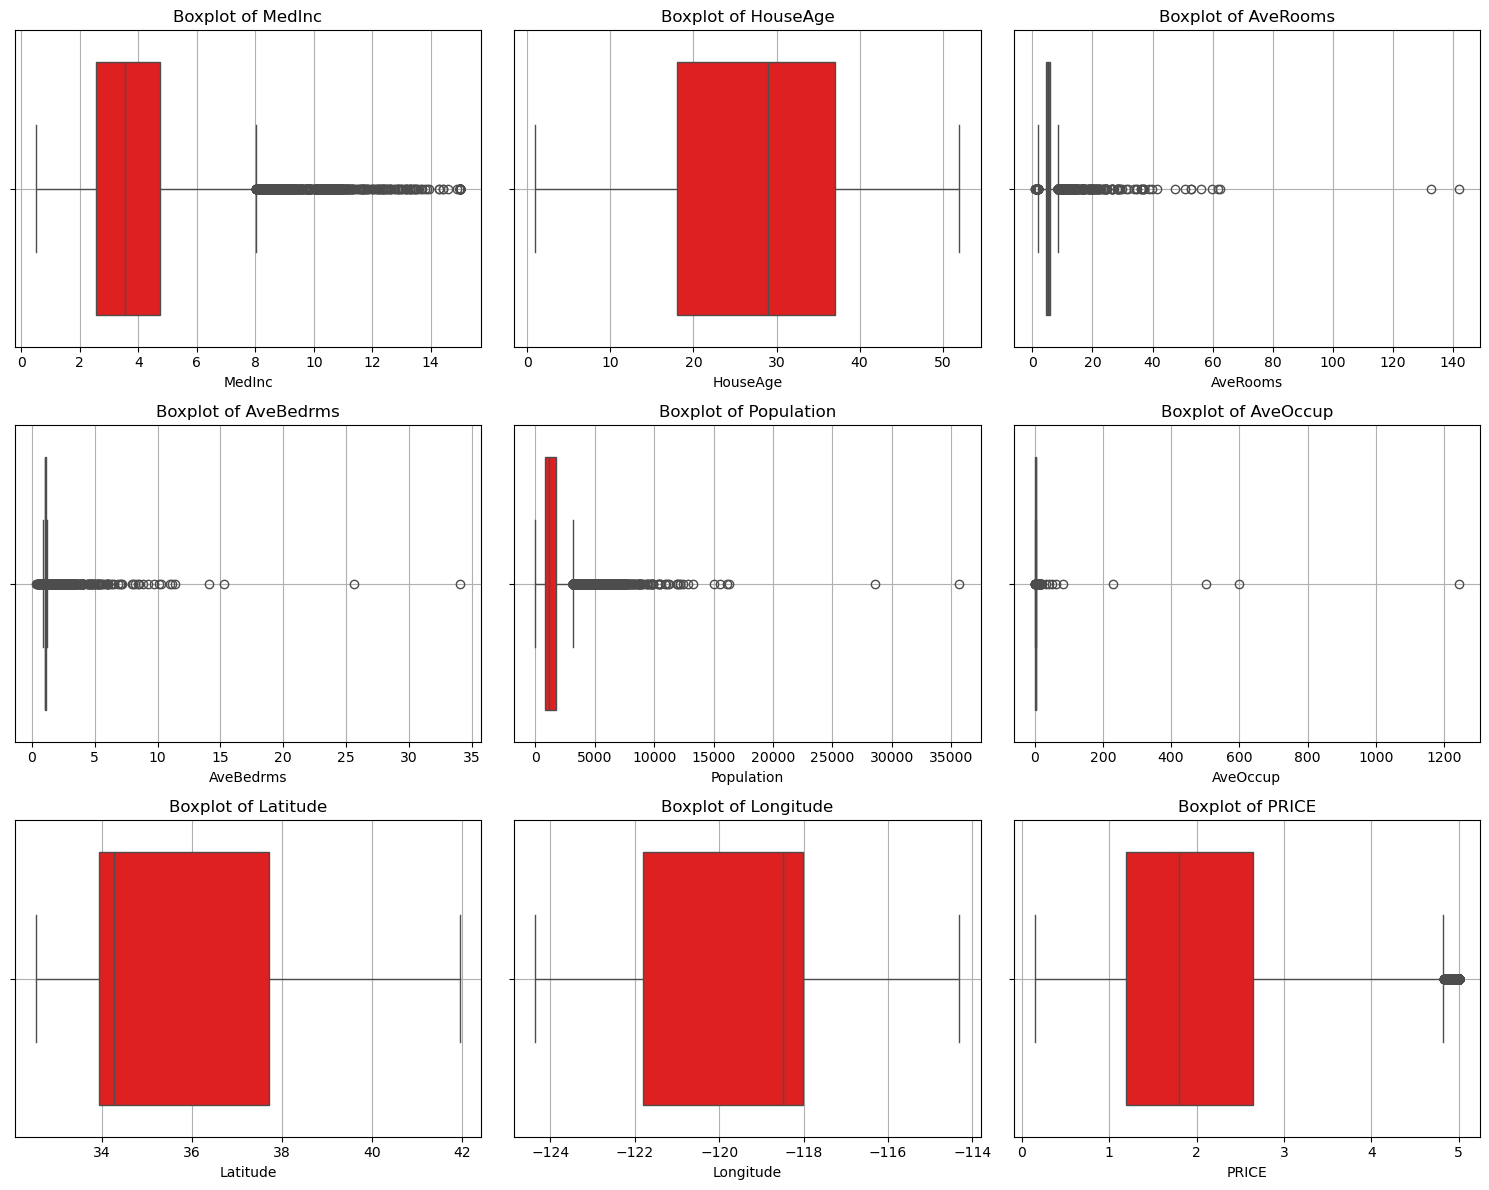

In [11]:
#Trực quan cụ thể outlier trên từng biến
cols = data.columns
n_cols = 3  # số cột mỗi hàng
n_rows = 3  # số hàng mỗi trang
plots_per_page = n_cols * n_rows
total = len(cols)
pages = math.ceil(total / plots_per_page)

for page in range(pages):
    start = page * plots_per_page
    end = min(start + plots_per_page, total)
    current_cols = cols[start:end]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(current_cols):
        sns.boxplot(x=data[col], ax=axes[i], color='red')
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].grid(True)

    # Ẩn subplot còn dư
    for j in range(len(current_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

Dựa trên kết quả kiểm tra outlier bằng phương pháp IQR, có thể rút ra một số kết luận sau:

Ba biến `HouseAge`, `Latitude` và `Longitude` không xuất hiện giá trị ngoại lai, cho thấy dữ liệu của chúng tương đối ổn định và nằm trong giới hạn hợp lý của tập mẫu. Đây thường là các biến mang tính địa lý hoặc giới hạn tự nhiên, nên không bị ảnh hưởng bởi giá trị cực đoan.

Ngược lại, các biến còn lại đều có outlier, trong đó `AveBedrms`, `Population` và `PRICE` là những biến có tỷ lệ ngoại lai cao nhất, lần lượt là 6.9%, 5.79% và 5.19%. Điều này phản ánh sự phân bố không đồng đều của dữ liệu ở một số khu vực, chẳng hạn như số phòng ngủ trung bình quá cao, dân cư tập trung quá đông, hoặc giá nhà vượt xa mức trung bình chung. Những biến này có thể cần xử lý hoặc kiểm tra thêm để đảm bảo tính ổn định của mô hình phân tích.

Các biến như `AveOccup`, `MedInc` và `AveRooms` cũng có outlier nhưng ở mức trung bình. Tùy vào mục đích nghiên cứu, những giá trị này có thể được giữ lại nếu phản ánh đúng đặc trưng thực tế của dữ liệu, hoặc được biến đổi để giảm ảnh hưởng đến kết quả phân tích.


In [12]:
# 2. Log-transform cho các biến lệch
data_transformed = data.copy()
cols_to_log = ['Population', 'PRICE', 'MedInc']

for col in cols_to_log:
    data_transformed[col] = np.log1p(data_transformed[col])  # log(1 + x)

# 3. Clipping cho các biến dễ có outlier
def clip_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower, upper=upper)
    return df

for col in ['AveBedrms', 'AveRooms', 'AveOccup']:
    data_transformed = clip_outliers_iqr(data_transformed, col)

# 4. Hàm kiểm tra lại outlier
def detect_outliers_iqr(df):
    outlier_info = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_info[col] = {
            "outlier_count": outliers.shape[0],
            "outlier_percent": round(100 * outliers.shape[0] / df.shape[0], 2)
        }
    return pd.DataFrame(outlier_info).T

# 5. Kiểm tra outlier sau xử lý
outliers_result = detect_outliers_iqr(data_transformed)
print("Outliers after transformation and clipping:")
print(outliers_result)

Outliers after transformation and clipping:
            outlier_count  outlier_percent
MedInc              226.0             1.09
HouseAge              0.0             0.00
AveRooms              0.0             0.00
AveBedrms             0.0             0.00
Population          848.0             4.11
AveOccup              0.0             0.00
Latitude              0.0             0.00
Longitude             0.0             0.00
PRICE                 0.0             0.00


In [13]:
# Clip tiếp các biến còn outlier
for col in ['Population', 'MedInc']:
    data_transformed = clip_outliers_iqr(data_transformed, col)

# Kiểm tra lại lần cuối
outliers_final = detect_outliers_iqr(data_transformed)
print("Final check – Outliers đã được xử lý hoàn toàn:")
print(outliers_final)


Final check – Outliers đã được xử lý hoàn toàn:
            outlier_count  outlier_percent
MedInc                0.0              0.0
HouseAge              0.0              0.0
AveRooms              0.0              0.0
AveBedrms             0.0              0.0
Population            0.0              0.0
AveOccup              0.0              0.0
Latitude              0.0              0.0
Longitude             0.0              0.0
PRICE                 0.0              0.0


#### **Lý do nhóm sử dụng các kỹ thuật để loại bỏ outliers (Log-transform và Clipping)**:

##### **1. Log-transform**:
   - **Giảm sự lệch và outliers**: 
     - **Log-transform** giúp giảm độ lệch (skewness) trong phân phối của các biến, giúp chúng gần với **phân phối chuẩn**. Việc này cực kỳ quan trọng trong các mô hình học máy yêu cầu dữ liệu có **phân phối chuẩn**, như **hồi quy tuyến tính** hoặc **SVM**.
     - **Các biến như `Population`, `MedInc`, và `PRICE`** thường có **phân phối lệch phải** với các giá trị cực đoan (outliers). **Log-transform** giúp làm giảm ảnh hưởng của các outliers này, làm cho phân phối trở nên đồng đều hơn và giúp mô hình học máy học dễ dàng hơn.
   
   - **Tại sao không áp dụng log-transform cho tất cả các biến**:
     - **Latitude và Longitude**: Các biến **địa lý** này đã có phân phối hợp lý, và việc **log-transform** có thể làm mất đi **ý nghĩa địa lý** vốn có của chúng. Các giá trị **vĩ độ** và **kinh độ** không có sự lệch mạnh, do đó không cần thiết phải chuyển đổi.
     - **HouseAge**: Biến này có thể không có phân phối lệch mạnh (tức là, phân phối khá đồng đều), vì vậy **log-transform** không cần thiết và có thể làm thay đổi tính chất của dữ liệu mà không có lợi cho mô hình.

   - **Lợi ích của log-transformation**:
     - **Giúp mô hình học máy nhận diện mối quan hệ tuyến tính dễ dàng hơn**: Đặc biệt khi có sự **lệch hoặc outliers** trong các biến, việc áp dụng log-transformation giúp mô hình dễ dàng học được mối quan hệ giữa các biến và giá trị mục tiêu (target).

##### **2. Clipping**:
   - **Lý do sử dụng Clipping**:
     - **Clipping** giúp xử lý các **outliers** bằng cách **giới hạn giá trị** của các điểm dữ liệu vượt quá một ngưỡng nhất định. Thay vì loại bỏ các điểm outliers, **clipping** giúp giữ lại dữ liệu nhưng làm giảm ảnh hưởng của các giá trị cực đoan.
     - Trong trường hợp **`AveRooms`, `HouseAge`, `AveOccup`**, những biến này có thể có các **outliers** cực kỳ cao hoặc thấp. **Clipping** giúp **kiểm soát các giá trị cực đoan** này mà không làm mất đi dữ liệu quan trọng khác.
     - Ví dụ, **`AveRooms`** có thể có các giá trị quá cao (các ngôi nhà với số phòng rất nhiều), việc **clipping** giúp giảm tác động của các giá trị này lên mô hình mà không làm thay đổi các giá trị hợp lý.
   
   - **Ưu điểm của Clipping**:
     - **Giữ lại dữ liệu mà không làm mất thông tin**: Các điểm dữ liệu không bị loại bỏ, nhưng thay vào đó được **giới hạn** trong phạm vi hợp lý. Điều này giúp tránh việc mất đi quá nhiều dữ liệu trong khi vẫn loại bỏ được các giá trị cực đoan.
     - **Điều chỉnh thang đo của các biến**: Với các biến có sự phân bố rộng và các outliers, **clipping** giúp **điều chỉnh các giá trị cực đoan** để chúng không gây ảnh hưởng quá mạnh đến mô hình.

##### **3. Tổng kết**:
   - **Log-transform** được sử dụng chủ yếu cho các biến có **phân phối lệch mạnh** hoặc có **outliers** rõ ràng, giúp làm **giảm độ lệch** và **điều chỉnh phân phối** của dữ liệu. Tuy nhiên, không phải tất cả các biến đều cần **log-transform**, đặc biệt là các biến như **Latitude** và **Longitude** mà không có phân phối lệch mạnh.
   - **Clipping** được sử dụng để **kiểm soát các outliers** mà không làm mất đi bất kỳ điểm dữ liệu nào. Các biến có **outliers lớn** như **`AveRooms`** và **`HouseAge`** có thể được **clipping** để giảm ảnh hưởng của chúng đến mô hình học máy.

Với **cả hai kỹ thuật này**, nhóm muốn **giữ lại càng nhiều dữ liệu càng tốt** trong khi **giảm thiểu ảnh hưởng của outliers** và giúp mô hình học máy **học tốt hơn** và **chính xác hơn**.

In [14]:
data_transformed.shape

(20640, 9)

Sau khi loại bỏ outliers vẫn giữ được số dòng dữ liệu như ban đầu.


### Kiểm tra, phân loại biến, chuyển các biến định tính về dạng số 

In [15]:
description = data_transformed.describe(include='all')
description

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       1.515745     28.639486      5.304740      1.057958      7.047496   
std        0.353923     12.585558      1.246177      0.080448      0.643394   
min        0.554750      1.000000      2.023219      0.865909      5.493402   
25%        1.270715     18.000000      4.440716      1.006079      6.669498   
50%        1.511781     29.000000      5.229129      1.048780      7.062192   
75%        1.748025     37.000000      6.052381      1.099526      7.453562   
max        2.463990     52.000000      8.469878      1.239697      8.629658   

           AveOccup      Latitude     Longitude         PRICE  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       2.899647     35.631861   -119.569704      1.056146  
std        0.691142      2.135952      2.003532      0.356212  
min        1.150961     32.540000   -124.350000      0.139753  
25%        2.429741     33.930000   -121.800000      0.786638  
50%        2.818116     34.260000   -118.490000      1.028547  
75%        3.282261     37.710000   -118.010000      1.293973  
max        4.561041     41.950000   -114.310000      1.791761

In [16]:
#Phân loại các cột
categorical_features = data.select_dtypes(include=['object']).columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns


In [17]:
# Thống kê cho categorical features
print("Categorical Features:")
print("=================================")
for feature in categorical_features:
    print(f"{feature}:\n{data[feature].value_counts()}\n")

Categorical Features:


Không có biến nào là biến định tính

In [18]:
# Thống kê cho numerical features
print("Numerical Features:")
# Thống kê mô tả chung cho dữ liệu số
print(data[numerical_features].describe())

Numerical Features:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         PRICE  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0

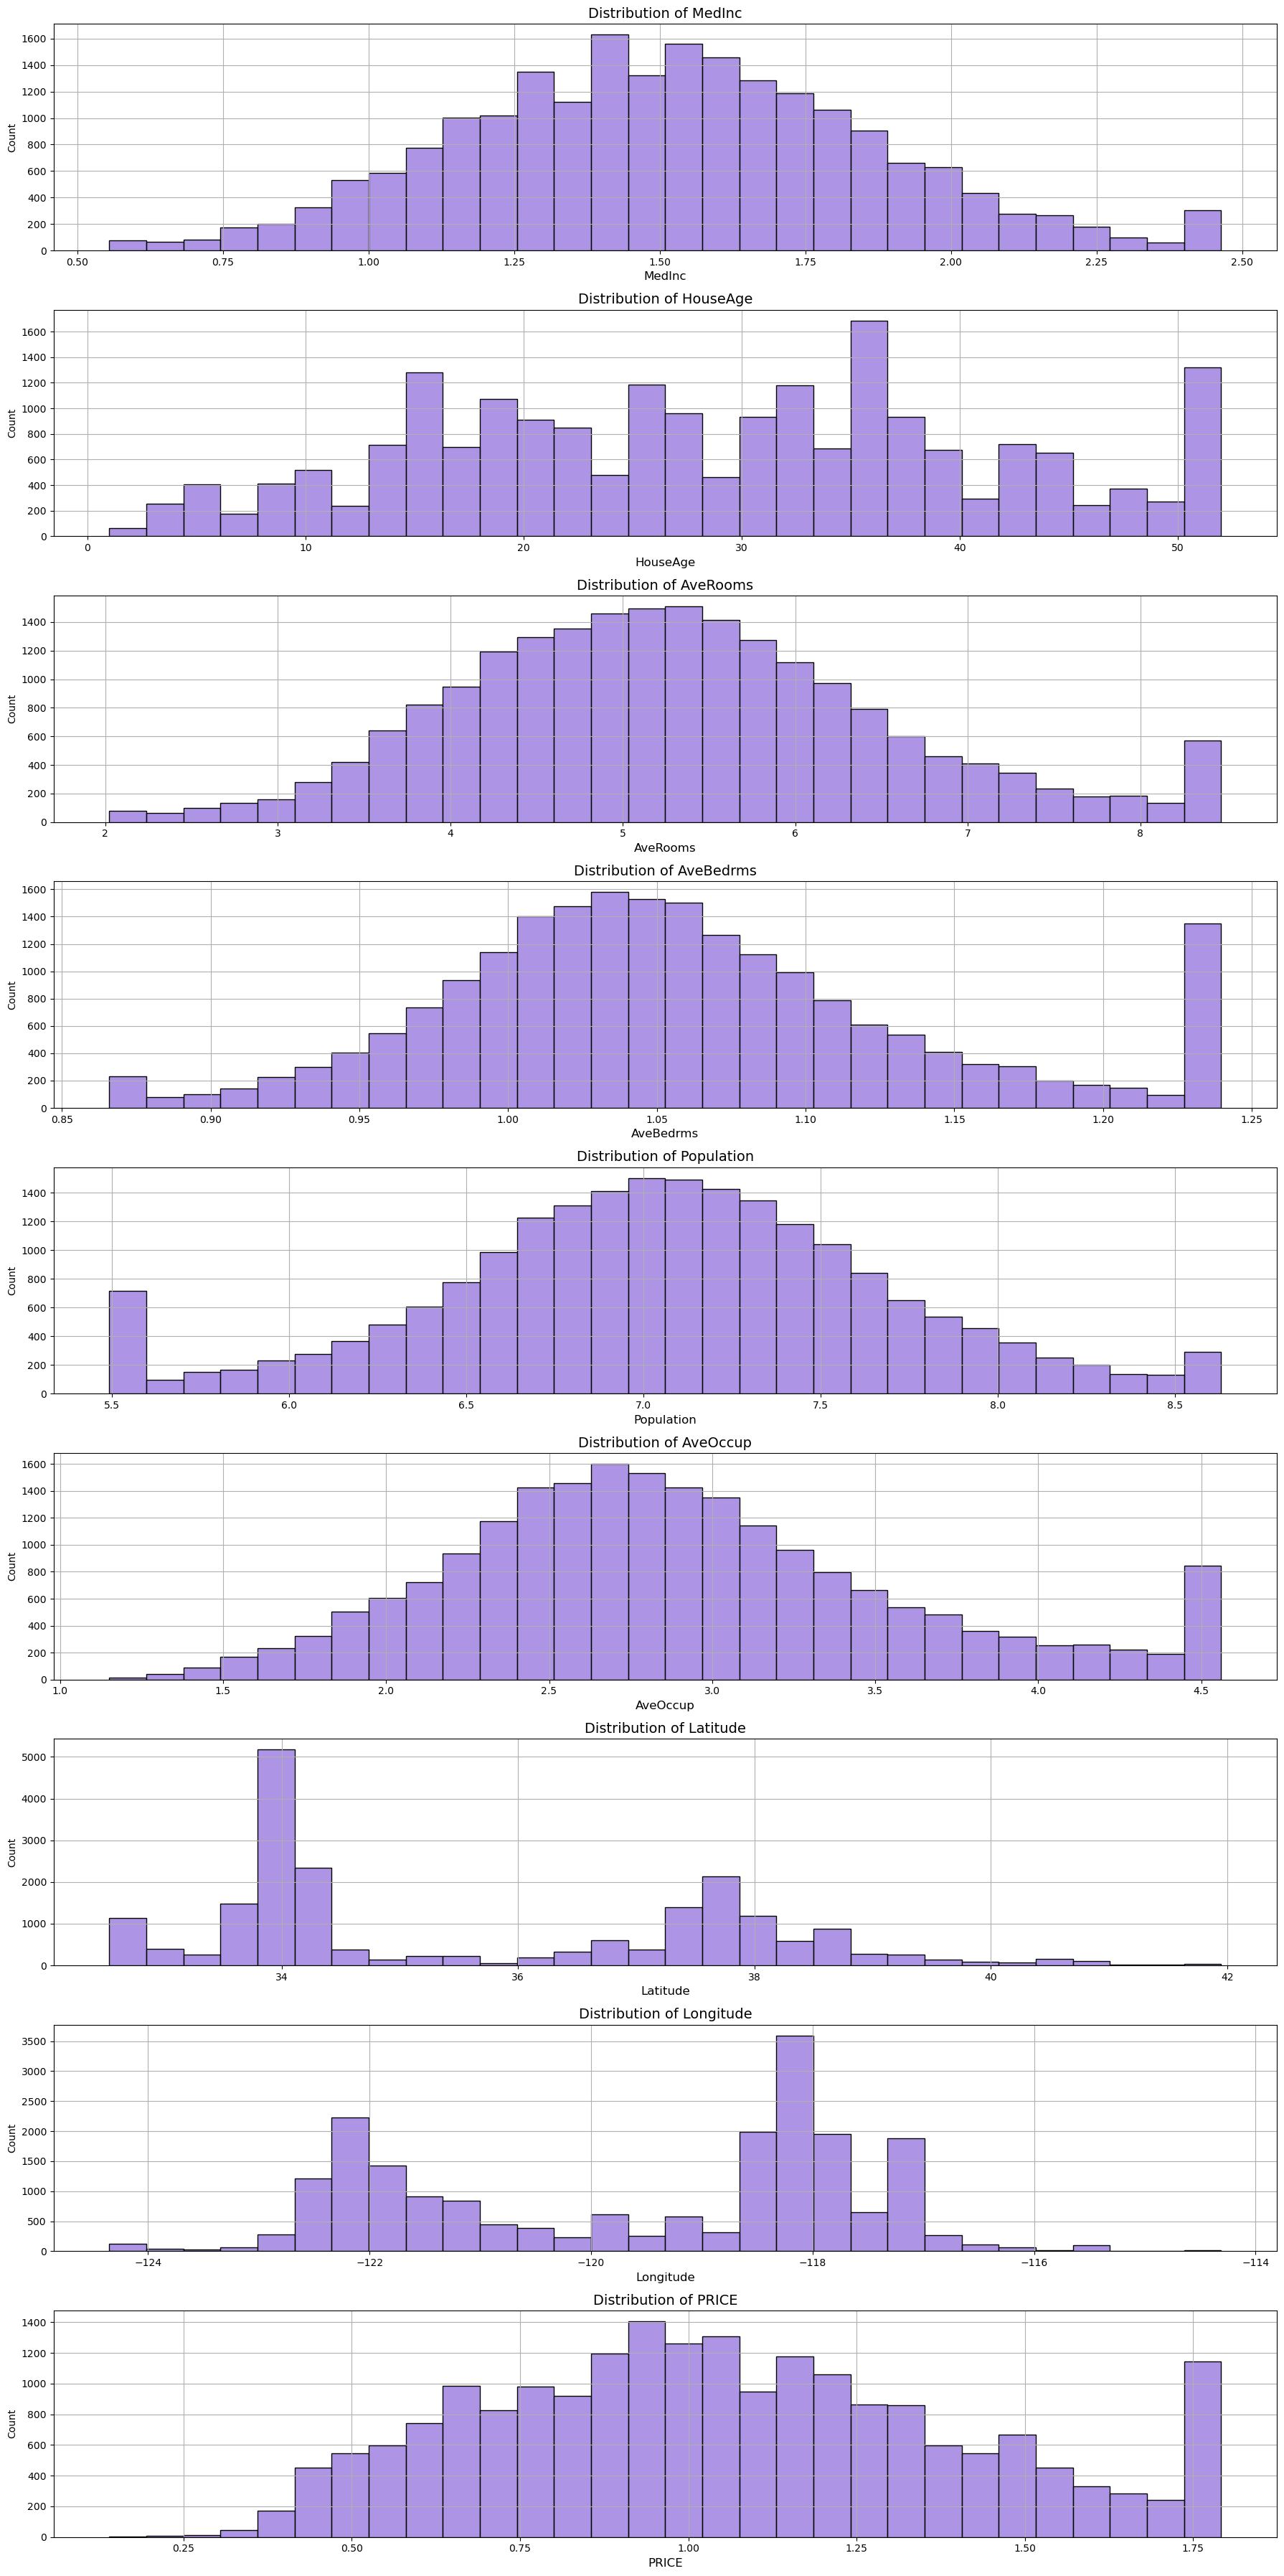

In [19]:
# Lấy tất cả các cột trong data_transformed
cols_to_check = data_transformed.columns

# Số dòng và cột trong subplot
n_rows = len(cols_to_check)
n_cols = 1

# Tạo subplot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Vẽ histogram cho từng cột
for i, col in enumerate(cols_to_check):
    sns.histplot(data_transformed[col], bins=30, kde=False, color='mediumpurple', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].tick_params(axis='x', labelsize=10)
    axes[i].grid(True)

# Tự động căn chỉnh layout
plt.tight_layout()
plt.show()

Mặc dù tất cả các biến trong tập dữ liệu California Housing đều được định dạng dạng số và được hệ thống thống kê xem là biến định lượng, tuy nhiên qua quá trình trực quan hóa và phân tích phân phối, một số biến thể hiện hành vi như biến định tính. Đặc biệt là các biến như HouseAge, AveOccup, AveBedrms, Latitude, và Longitude có phân phối cụm, nhiễu cao hoặc mang ý nghĩa phân loại vùng. Mục đích của nhóm là  chuyển những biến này sang dạng định tính (categorical) giúp mô hình học tốt hơn và giảm thiểu nhiễu từ giá trị không mang ý nghĩa toán học.



#####  **Phân tích phân phối và đề xuất chuyển đổi biến định lượng thành định tính**

Để hiểu rõ hơn về bản chất các biến trong tập dữ liệu California Housing, nhóm đã trực quan hóa phân phối của một số biến định lượng bằng biểu đồ histogram. Mặc dù các biến này được hệ thống phân loại là dạng số, kết quả trực quan cho thấy nhiều biến có hành vi tương tự biến định tính. Cụ thể:

###### 1. `HouseAge` – Tuổi trung bình của nhà ở khu vực
Biểu đồ phân phối của biến `HouseAge` cho thấy dữ liệu được gom thành các cụm rõ rệt tại các mức tuổi tròn như 15, 20, 30, 35 và 50. Điều này phản ánh thực tế là các khu dân cư thường được xây dựng theo từng đợt và có tuổi nhà đồng đều. Do vậy, việc giữ `HouseAge` dưới dạng số liên tục có thể gây nhiễu cho mô hình. Thay vào đó, có thể nhóm thành ba mức: nhà mới (0–20 năm), nhà trung niên (21–40 năm) và nhà cũ (>40 năm).

###### 2. `AveOccup` – Số người trung bình trên mỗi hộ
Biến này có phân phối gần chuẩn, tập trung mạnh quanh giá trị 2.5–3.5. Tuy nhiên, do phần lớn giá trị rơi vào khoảng hẹp, các mức cao và thấp mang tính bất thường và có thể ảnh hưởng đến mô hình tuyến tính. Việc phân nhóm thành các mức "thấp", "trung bình" và "cao" sẽ giúp làm mượt dữ liệu và tăng khả năng tổng quát hóa của mô hình.

###### 3. `AveBedrms` – Số phòng ngủ trung bình mỗi hộ
Dù biểu đồ gần giống phân phối chuẩn, dữ liệu tập trung gần như tuyệt đối quanh khoảng 1.0–1.1. Điều này cho thấy sự biến thiên là rất nhỏ và khó mang lại giá trị khi sử dụng như biến định lượng. Việc phân loại biến này theo các ngưỡng có thể giúp mô hình hiểu rõ ranh giới giữa khu vực ít phòng ngủ và nhiều phòng ngủ hơn.

###### 4. `Latitude` và `Longitude` – Tọa độ địa lý
Hai biến tọa độ có phân phối thành từng cụm dân cư rõ ràng. Điều này phản ánh sự tập trung dân số tại các khu đô thị lớn như Los Angeles, San Francisco, v.v. Tọa độ không nên được đưa vào mô hình như các giá trị liên tục do không có ý nghĩa toán học theo trục tọa độ. Do đó, nên nhóm các khu vực này thành các vùng địa lý như Bắc California, Trung California và Nam California để phản ánh đặc điểm vùng.

##### Kết luận:
Mặc dù các biến nêu trên có dạng số, trực quan hóa đã chỉ ra hành vi phân loại ẩn trong phân phối dữ liệu. Việc chuyển đổi một số biến định lượng thành định tính không chỉ phù hợp về mặt logic mà còn giúp tăng độ linh hoạt, khả năng học của mô hình và cải thiện khả năng diễn giải kết quả.


#### Chuyển biến định tính về dạng số

In [20]:
# Sao chép dữ liệu
data_binned = data_transformed.copy()

# Rời rạc hóa các biến nghi ngờ có tính chất định tính ẩn bằng nhãn số
data_binned['HouseAge_cat'] = pd.cut(data_binned['HouseAge'],
                                     bins=[0, 20, 40, data_binned['HouseAge'].max()],
                                     labels=[1, 2, 3])

data_binned['AveOccup_cat'] = pd.cut(data_binned['AveOccup'],
                                     bins=[0, 2, 4, data_binned['AveOccup'].max()],
                                     labels=[1, 2, 3])

data_binned['AveBedrms_cat'] = pd.cut(data_binned['AveBedrms'],
                                      bins=[0, 1.0, 1.1, data_binned['AveBedrms'].max()],
                                      labels=[1, 2, 3])

data_binned['Region_lat'] = pd.cut(data_binned['Latitude'],
                                   bins=[32, 35, 37.5, 42],
                                   labels=[1, 2, 3])

data_binned['Region_long'] = pd.cut(data_binned['Longitude'],
                                    bins=[-125, -122, -119, -114],
                                    labels=[1, 2, 3])

# Chuyển tất cả thành kiểu category
categorical_cols = ['HouseAge_cat', 'AveOccup_cat', 'AveBedrms_cat', 'Region_lat', 'Region_long']
data_binned[categorical_cols] = data_binned[categorical_cols].astype('category')

# Mô tả thống kê các biến định tính
print(data_binned[categorical_cols].describe())


        HouseAge_cat  AveOccup_cat  AveBedrms_cat  Region_lat  Region_long
count          20640         20640          20640       20640        20640
unique             3             3              3           3            3
top                2             2              2           1            3
freq           10469         17248          10846       11294        10982


In [21]:
data_binned

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
0      2.232720      41.0  6.984127   1.023810    5.777652  2.555556   
1      2.230165      21.0  6.238137   0.971880    7.784057  2.109842   
2      2.111110      52.0  8.288136   1.073446    6.208590  2.802260   
3      1.893579      52.0  5.817352   1.073059    6.326149  2.547945   
4      1.578195      52.0  6.281853   1.081081    6.338594  2.181467   
...         ...       ...       ...        ...         ...       ...   
20635  0.940124      25.0  5.045455   1.133333    6.740519  2.560606   
20636  1.268861      18.0  6.114035   1.239697    5.877736  3.122807   
20637  0.993252      17.0  5.205543   1.120092    6.915723  2.325635   
20638  1.053336      18.0  5.329513   1.171920    6.609349  2.123209   
20639  1.220417      16.0  5.254717   1.162264    7.235619  2.616981   

       Latitude  Longitude     PRICE HouseAge_cat AveOccup_cat AveBedrms_cat  \
0         37.88    -122.23  1.709464            3            2             2   
1         37.86    -122.22  1.522790            2            2             1   
2         37.85    -122.24  1.508733            3            2             2   
3         37.85    -122.25  1.484555            3            2             2   
4         37.85    -122.25  1.486592            3            2             2   
...         ...        ...       ...          ...          ...           ...   
20635     39.48    -121.09  0.577175            2            2             3   
20636     39.49    -121.21  0.571544            1            2             3   
20637     39.43    -121.22  0.653886            1            2             3   
20638     39.43    -121.32  0.613563            1            2             3   
20639     39.37    -121.24  0.638691            1            2             3   

      Region_lat Region_long  
0              3           1  
1              3           1  
2              3           1  
3              3           1  
4              3           1  
...          ...         ...  
20635          3           2  
20636          3           2  
20637          3           2  
20638          3           2  
20639          3           2  

[20640 rows x 14 columns]

## 2. Khám phá dữ liệu và trực quan hóa

### Vẽ biểu đồ phân phối, scatter plot để phân tích mối quan hệ giữa các biến

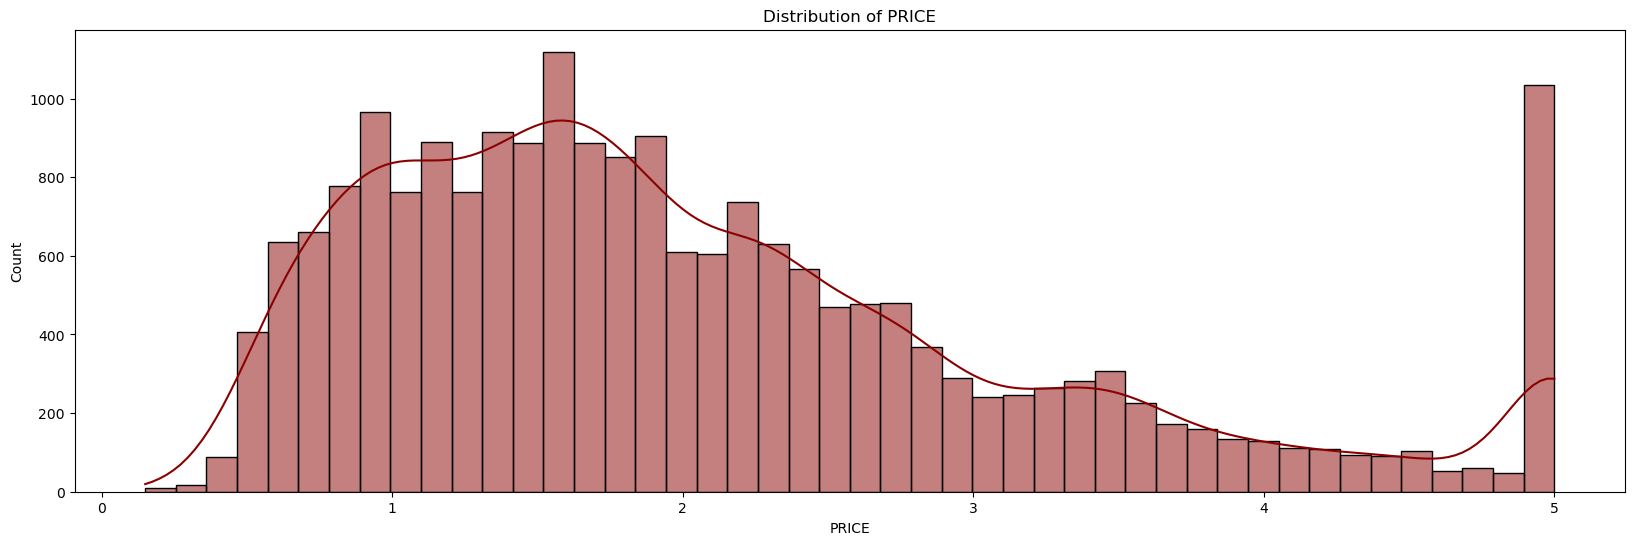

In [22]:
# Thiết lập kích thước hình ảnh
plt.figure(figsize=(20, 6))

# Phân phối của biến mục tiêu (price)
sns.histplot(data['PRICE'], kde=True, color='darkred')
plt.title('Distribution of PRICE')
plt.show()

1. Phân phối lệch trái nhẹ (left-skewed):

Đỉnh phân phối nằm lệch về phía phải (khoảng giá từ 1 đến 2), cho thấy đa phần các khu vực có giá nhà trung bình thuộc nhóm thấp đến trung bình (sau log-transform).

Tuy nhiên, vẫn có một lượng đáng kể khu vực có giá nhà rất cao (~ log(5)), tạo thành một “cụm cao bất thường” ở cuối.

2. Hai cực rõ rệt:

Một cụm lớn dân cư sống ở các khu vực giá thấp (~1–2)

Một cụm nhỏ nhưng rõ rệt ở mức rất cao (~4.9–5) → Có thể là các khu vực cao cấp (gần biển, trung tâm…)

3. Dấu hiệu cắt ngưỡng (censoring):

Giá trị 5.0 xuất hiện đột ngột với tần suất cao → Có khả năng là ngưỡng trần khi dữ liệu được thu thập (capping), tức là mọi giá trị >5 bị gộp lại.

Điều này có thể ảnh hưởng đến mô hình dự đoán, vì mô hình sẽ không biết sự khác biệt giữa giá trị 5 và thực tế là 6, 7, v.v.

#### Mối quan hệ giữa features -> target

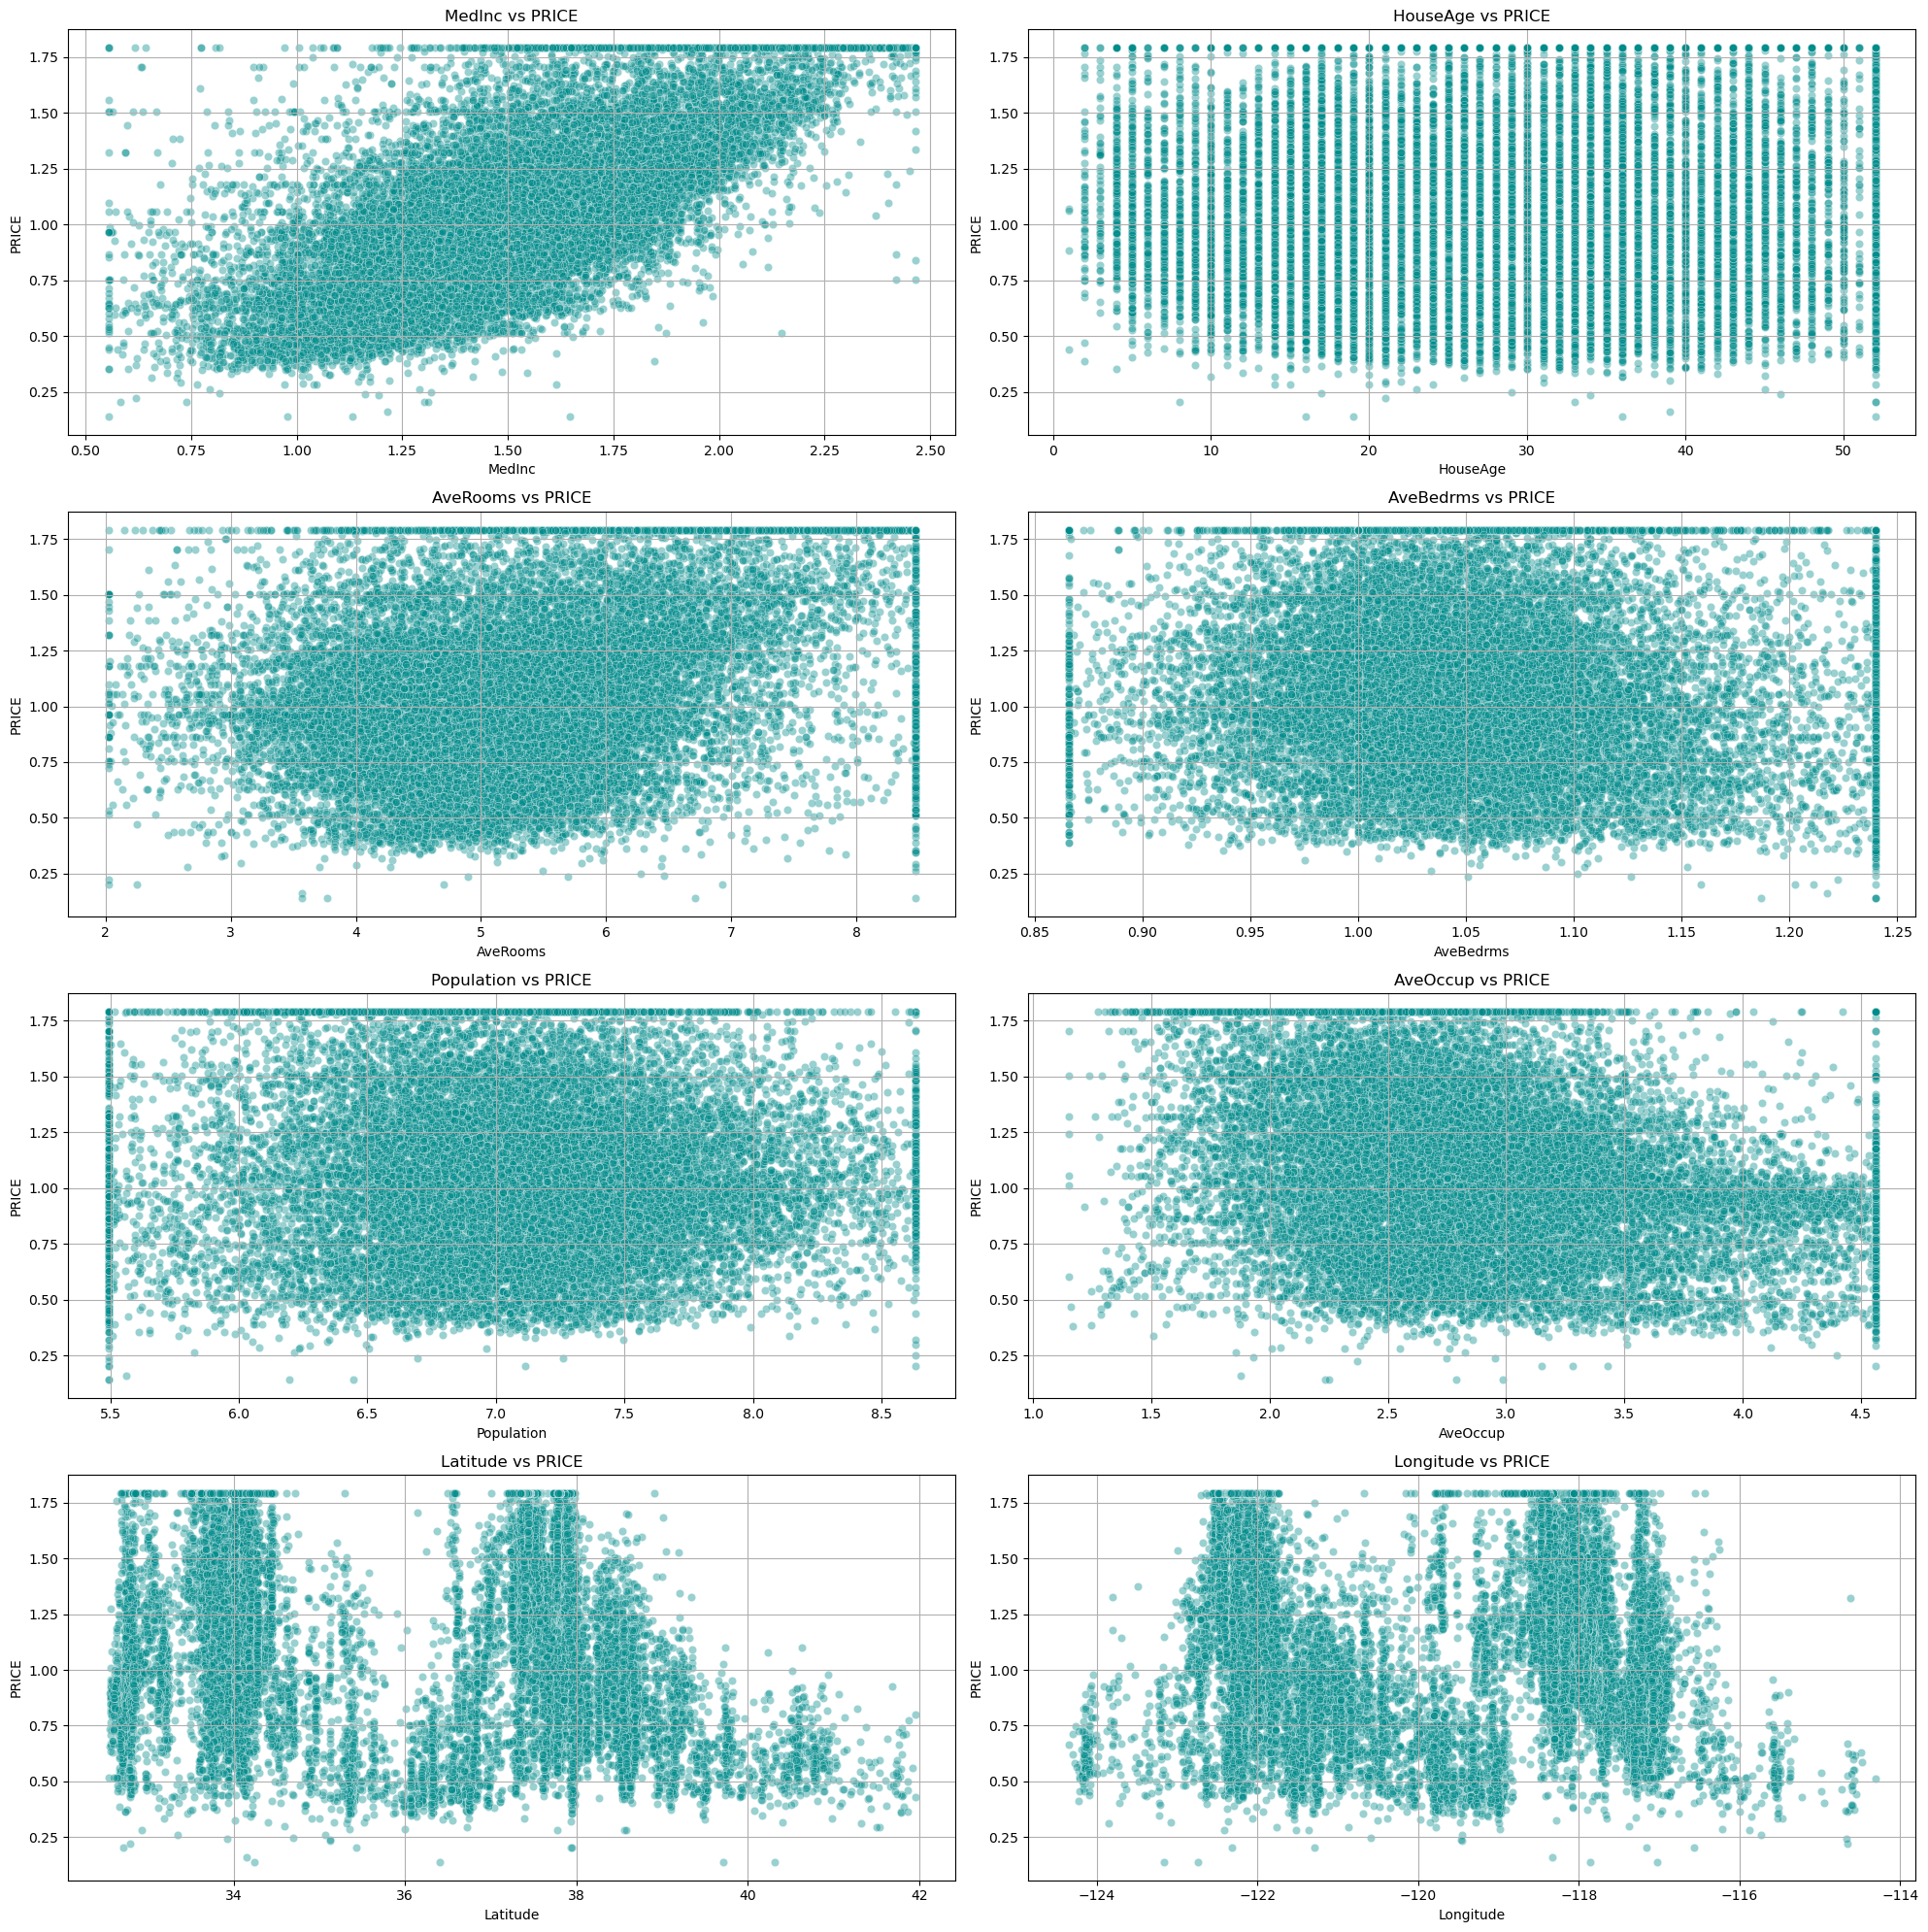

In [23]:
def plot_scatter_with_target(df, target='PRICE'):
    # Lấy các biến dạng số trừ biến mục tiêu
    numerical_cols = df.select_dtypes(include='number').drop(columns=[target])
    num_plots = len(numerical_cols.columns)
    
    # Xác định số hàng và cột phù hợp
    n_cols = 2
    n_rows = math.ceil(num_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    axes = axes.flatten()

    # Vẽ từng scatter plot
    for i, feature in enumerate(numerical_cols.columns):
        sns.scatterplot(x=df[feature], y=df[target], alpha=0.4, color='darkcyan', ax=axes[i])
        axes[i].set_title(f'{feature} vs {target}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target)
        axes[i].grid(True)

    # Ẩn subplot dư (nếu có)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Gọi hàm
plot_scatter_with_target(data_binned)


**Nhận xét chi tiết từng biến:**

##### 1. **MedInc (Median Income) vs PRICE**
- Mối quan hệ **tương đối rõ ràng và tuyến tính dương**: thu nhập càng cao → giá nhà càng cao.
- Đây là **biến có sức phân biệt mạnh nhất** đối với `PRICE`.

##### 2. **HouseAge vs PRICE**
- Phân bố **gần như đều** và không có xu hướng rõ ràng.
- Có thể thấy **giá nhà không phụ thuộc tuyến tính vào tuổi nhà**, nhưng có vẻ giá nhà ở các khu nhà cũ hơn (40–50 năm) có phần nhỉnh hơn.
- Nhóm sẽ kiểm tra mối quan hệ theo phân loại của HouseAge vs PRICE

##### 3. **AveRooms vs PRICE**
- Mối quan hệ **rất yếu** và **rải rác**. Không thể hiện xu hướng tăng/giảm rõ ràng.
- Nhiều điểm nằm trên mức trần `PRICE` cho thấy có thể bị ảnh hưởng bởi giới hạn mô hình.
- Nhóm có thể cân nhắc kết hợp với `AveBedrms` để tạo biến mới hoặc không.

##### 4. **AveBedrms vs PRICE**
- Phân bố rất **chặt và hẹp** (nằm giữa 0.85–1.25) → thiếu sự biến thiên → **khó đóng góp nhiều cho mô hình**.
- Có thể loại bỏ hoặc chỉ giữ nếu có ý nghĩa sau biến đổi kết hợp.

##### 5. **Population vs PRICE**
- Không có mối liên hệ tuyến tính rõ ràng.
- Càng đông dân không đồng nghĩa với giá cao → cần thêm thông tin vùng/quận để hỗ trợ.

##### 6. **AveOccup (Average Occupants per Household) vs PRICE**
- Có xu hướng **giảm nhẹ**: khu vực có mật độ người/hộ thấp thì giá nhà cao hơn (có thể là vùng giàu hơn).
- Tuy nhiên, mối quan hệ **khá yếu**.
- Nhóm sẽ kiểm tra mối quan hệ theo phân loại của AveOccup vs PRICE

##### 7. **Latitude vs PRICE**
- Mối quan hệ **rất thú vị**: các cụm giá trị `PRICE` phân bố **theo từng vĩ độ cụ thể**.
- Có vẻ như giá nhà **cao hơn ở các vùng vĩ độ thấp (~33–35, miền Nam California)**, nơi có thành phố lớn như Los Angeles.
- Nên giữ lại biến này hoặc dùng để tạo nhóm (`region_lat`).
- Nhóm sẽ kiểm tra mối quan hệ theo phân loại của Latitude vs PRICE

##### 8. **Longitude vs PRICE**
- Tương tự `Latitude`, có sự **tập trung của giá nhà cao quanh vùng -122 đến -118**, tức là vùng gần biển (San Francisco, LA).
- Đây là **biến vị trí mạnh** và nhóm cân nhắc tạo biến mới.
- Nhóm sẽ kiểm tra mối quan hệ theo phân loại của Longitude vs PRICE

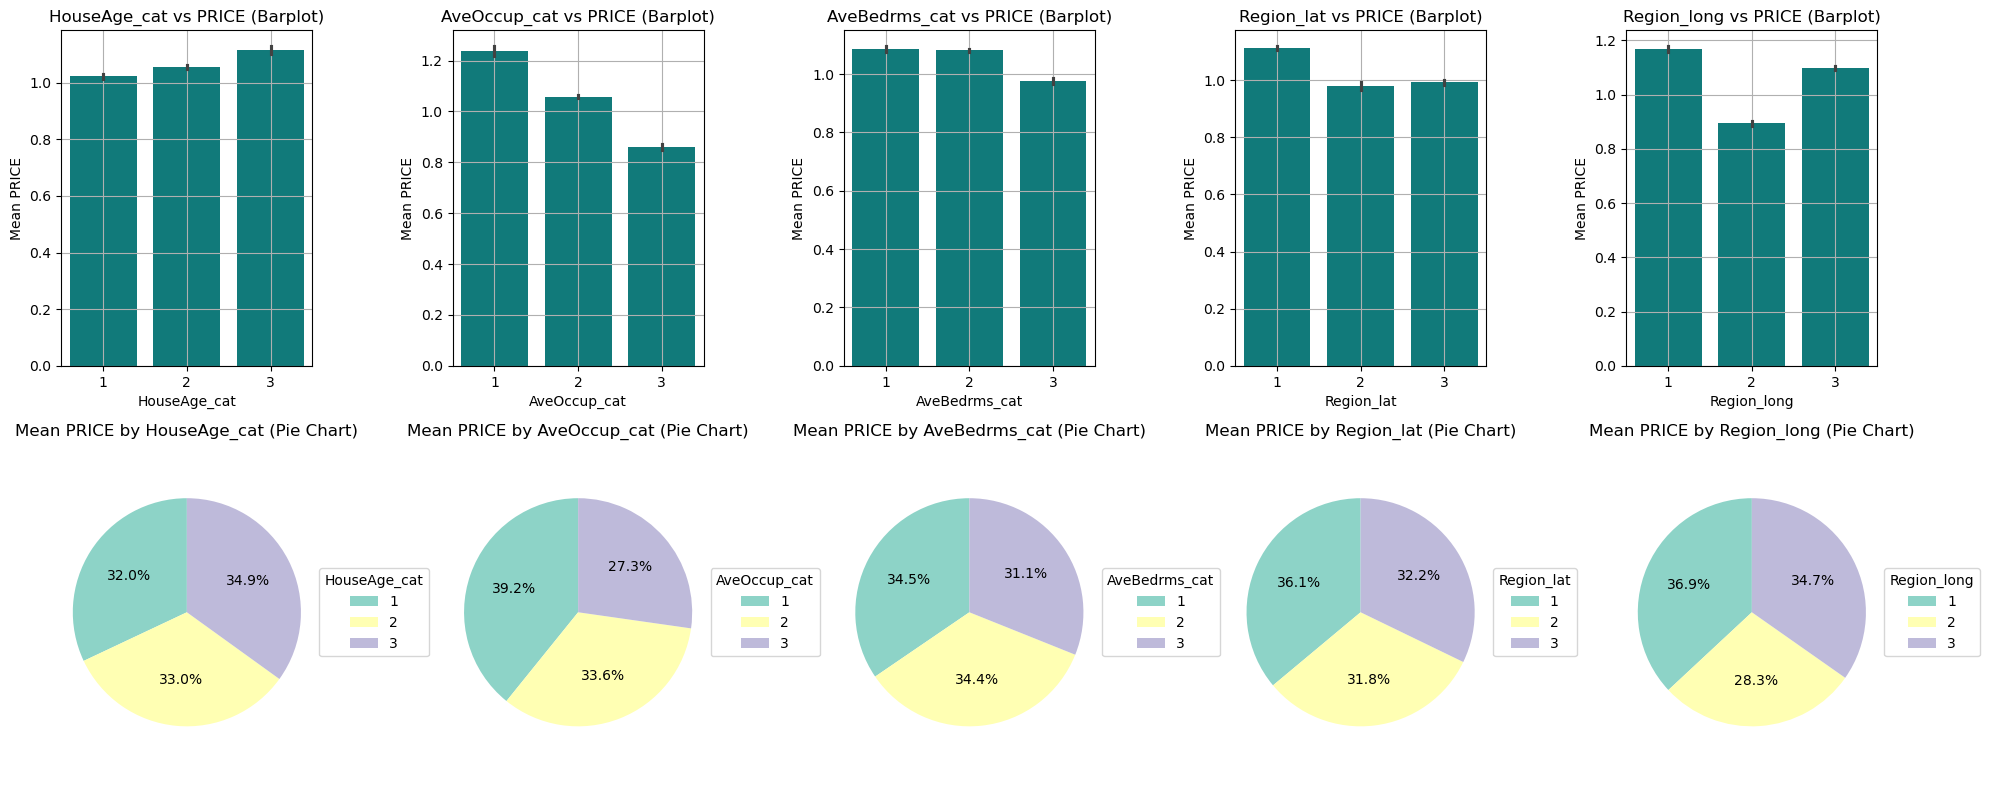

In [24]:
def plot_bar_and_pie_with_target(df, target='PRICE'):
    # Lọc các biến định tính
    categorical_cols = df.select_dtypes(include=['category']).columns.tolist()

    # Tạo các subplot
    fig, axes = plt.subplots(2, len(categorical_cols), figsize=(20, 8))  # 2 hàng cho bar và pie

    if len(categorical_cols) == 1:
        axes = [axes]  # Đảm bảo axes là list nếu chỉ có một biến

    # Vẽ barplot và pie chart cho từng biến định tính
    for i, feature in enumerate(categorical_cols):
        # Barplot
        sns.barplot(x=df[feature], y=df[target], color='darkcyan', ax=axes[0, i])
        axes[0, i].set_title(f'{feature} vs {target} (Barplot)')
        axes[0, i].set_xlabel(feature)
        axes[0, i].set_ylabel(f'Mean {target}')
        axes[0, i].grid(True)

        # Biểu đồ tròn (Pie chart)
        mean_price_by_category = df.groupby(feature)[target].mean()
        wedges, texts, autotexts = axes[1, i].pie(mean_price_by_category, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(mean_price_by_category)))

        # Thêm tiêu đề và chú thích cho pie chart
        axes[1, i].set_title(f'Mean {target} by {feature} (Pie Chart)')
        axes[1, i].axis('equal')  # Đảm bảo hình tròn đúng tỉ lệ
        labels = mean_price_by_category.index  # Tên các nhóm
        axes[1, i].legend(wedges, labels, title=feature, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.tight_layout()  # Cải thiện việc sắp xếp các biểu đồ
    plt.show()

# Vẽ barplot và pie chart giữa các biến định tính và `PRICE`
plot_bar_and_pie_with_target(data_binned)



**Nhận xét mối quan hệ giữa các biến phân loại và `PRICE`**

##### 1. **HouseAge_cat vs PRICE**
- **Bar chart** cho thấy:
  - `HouseAge_cat = 3` (tức nhà cũ hơn) có giá nhà trung bình **cao nhất**.
  - `HouseAge_cat = 1` (nhà mới hơn) lại thấp hơn.
- Điều này gợi ý rằng **khu vực có nhà lâu đời có thể là khu đắt đỏ hơn** (trung tâm đô thị hoặc khu cổ).
- **Pie chart**: Các nhóm tuổi nhà được phân bố tương đối đều (32% – 35%).
**Có mối quan hệ nhẹ giữa tuổi nhà và giá** – không tuyến tính nhưng đáng cân nhắc.

##### 2. **AveOccup_cat vs PRICE**
- **Rõ ràng có xu hướng nghịch đảo**:
  - Càng nhiều người ở mỗi hộ → giá nhà trung bình càng thấp.
- Điều này có thể phản ánh khu vực **mật độ cư trú cao thường ít cao cấp hơn**.
*Mối quan hệ nghịch chiều hợp lý*, nên giữ lại biến này.

##### 3. **AveBedrms_cat vs PRICE**
- Giá trung bình giữa 3 nhóm khá **tương đương** (không chênh lệch rõ rệt).
- Có thể **biến này không có sức phân biệt cao** sau khi đã binned.
**Không có mối quan hệ rõ**, cần cân nhắc giữ/lược bỏ.

##### 4. **Region_lat vs PRICE**
- Khu vực theo **latitude** có chênh lệch giá:
  - `Region_lat = 1` cao nhất → đây có thể là miền Nam California (vĩ độ thấp, gần LA)
  - `Region_lat = 2` thấp nhất → có thể là miền trung nội địa
- **Pie chart**: Các vùng địa lý chia đều, đảm bảo cân bằng nhóm.
**Mối quan hệ địa lý rõ ràng** – rất nên giữ.

##### 5. **Region_long vs PRICE**
- `Region_long = 1` có giá cao nhất, sau đó là 3, thấp nhất là 2.
- Điều này phản ánh sự khác biệt theo **vị trí đông–tây**, có thể liên quan đến khoảng cách biển.
- **Pie chart** cho thấy nhóm 2 chiếm tỷ lệ thấp nhất (~28.3%) nhưng có giá trung bình thấp nhất.
**Rất phù hợp với giả định địa lý → mạnh mẽ về ý nghĩa và logic**.


In [25]:
data_binned

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
0      2.232720      41.0  6.984127   1.023810    5.777652  2.555556   
1      2.230165      21.0  6.238137   0.971880    7.784057  2.109842   
2      2.111110      52.0  8.288136   1.073446    6.208590  2.802260   
3      1.893579      52.0  5.817352   1.073059    6.326149  2.547945   
4      1.578195      52.0  6.281853   1.081081    6.338594  2.181467   
...         ...       ...       ...        ...         ...       ...   
20635  0.940124      25.0  5.045455   1.133333    6.740519  2.560606   
20636  1.268861      18.0  6.114035   1.239697    5.877736  3.122807   
20637  0.993252      17.0  5.205543   1.120092    6.915723  2.325635   
20638  1.053336      18.0  5.329513   1.171920    6.609349  2.123209   
20639  1.220417      16.0  5.254717   1.162264    7.235619  2.616981   

       Latitude  Longitude     PRICE HouseAge_cat AveOccup_cat AveBedrms_cat  \
0         37.88    -122.23  1.709464            3            2             2   
1         37.86    -122.22  1.522790            2            2             1   
2         37.85    -122.24  1.508733            3            2             2   
3         37.85    -122.25  1.484555            3            2             2   
4         37.85    -122.25  1.486592            3            2             2   
...         ...        ...       ...          ...          ...           ...   
20635     39.48    -121.09  0.577175            2            2             3   
20636     39.49    -121.21  0.571544            1            2             3   
20637     39.43    -121.22  0.653886            1            2             3   
20638     39.43    -121.32  0.613563            1            2             3   
20639     39.37    -121.24  0.638691            1            2             3   

      Region_lat Region_long  
0              3           1  
1              3           1  
2              3           1  
3              3           1  
4              3           1  
...          ...         ...  
20635          3           2  
20636          3           2  
20637          3           2  
20638          3           2  
20639          3           2  

[20640 rows x 14 columns]

### Áp dụng PCA với 2 thành phần chính, sau đó vẽ mặt phẳng 2D của dữ liệu và tô màu theo giá nhà để trực quan hóa

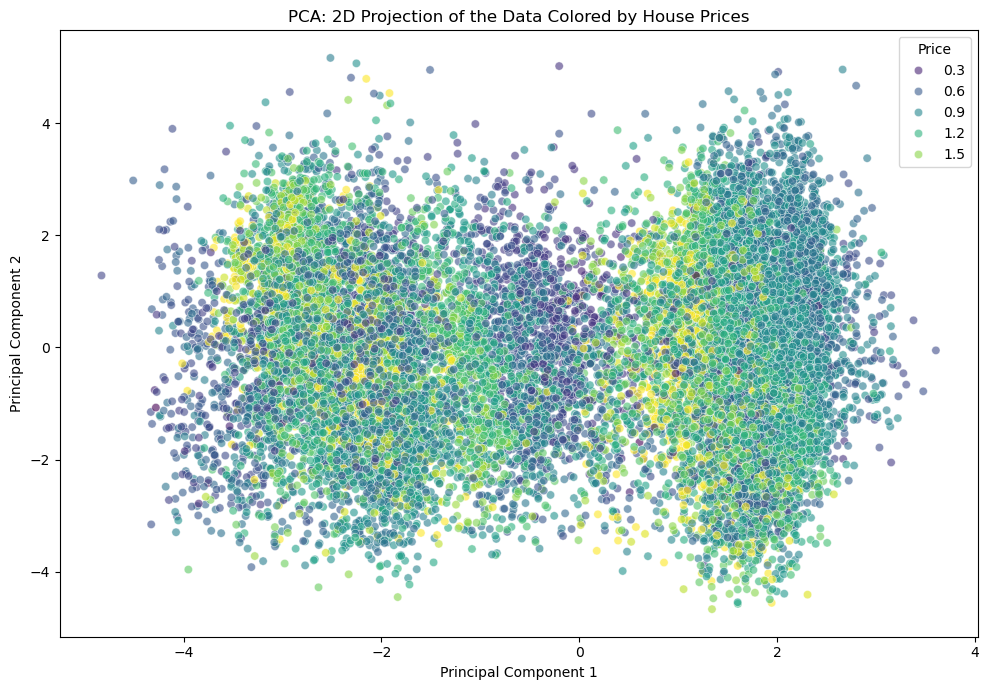

In [26]:
# 1. Lấy dữ liệu định lượng (numerical) mà không bao gồm giá nhà
X = data_binned.drop(columns=['PRICE'])

# 2. Chuẩn hóa dữ liệu (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Áp dụng PCA với 2 thành phần chính
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. Tạo DataFrame cho PCA
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# 5. Thêm giá trị mục tiêu (PRICE) vào DataFrame để tô màu
pca_df['PRICE'] = data_binned['PRICE']

# 6. Vẽ mặt phẳng 2D với màu sắc theo giá nhà
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='PRICE', palette='viridis', data=pca_df, alpha=0.6)
plt.title('PCA: 2D Projection of the Data Colored by House Prices')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Price')
plt.tight_layout()
plt.show()

Để đánh giá cấu trúc tổng thể của dữ liệu và khả năng phân biệt theo biến mục tiêu `PRICE`, nhóm nghiên cứu đã áp dụng kỹ thuật **Phân tích thành phần chính (Principal Component Analysis – PCA)** nhằm giảm chiều dữ liệu xuống còn hai thành phần chính (PC1 và PC2). Sau đó, toàn bộ tập dữ liệu được biểu diễn trên mặt phẳng hai chiều này và tô màu theo giá trị `PRICE`.

Kết quả biểu đồ PCA cho thấy:

- **Dữ liệu phân tán tương đối đồng đều**, không hình thành các cụm rõ ràng. Điều này cho thấy dữ liệu ban đầu không sở hữu cấu trúc phân nhóm mạnh mẽ, hoặc các đặc trưng chưa đủ để chia tách rõ rệt theo giá nhà.
  
- Tuy nhiên, **một xu hướng tuyến tính nhẹ xuất hiện dọc theo trục PC1**. Cụ thể, khu vực phía bên phải (PC1 > 0) có nhiều điểm dữ liệu có màu sáng hơn – biểu thị mức `PRICE` cao hơn, trong khi phía bên trái (PC1 < 0) tập trung các điểm có giá trị thấp hơn. Đây là dấu hiệu cho thấy **thành phần chính đầu tiên có mối quan hệ nhất định với biến mục tiêu**, nhiều khả năng tổng hợp ảnh hưởng từ các biến như `MedInc`, `Latitude`, hoặc `AveOccup`.

- Trục PC2 không thể hiện xu hướng rõ ràng với `PRICE`, cho thấy chiều thứ hai này có thể mang thông tin bổ sung không trực tiếp ảnh hưởng đến biến mục tiêu, nhưng vẫn có giá trị trong mô hình phi tuyến.

Việc trực quan hóa dữ liệu sau PCA không chỉ giúp đơn giản hóa không gian đặc trưng mà còn hỗ trợ phát hiện các xu hướng tiềm ẩn. Mặc dù không phát hiện được cụm giá rõ ràng, việc **PCA hé lộ mối liên hệ ngầm giữa hướng của PC1 và giá nhà** là một cơ sở quan trọng để cân nhắc các hướng tiếp cận phi tuyến (như Random Forest hoặc XGBoost) trong các bước mô hình hóa phía dưới.

#### Kiểm tra tỷ lệ phương sai giải thích:

In [27]:
# Kiểm tra tỷ lệ phương sai được giải thích bởi các thành phần chính
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio by each component: {explained_variance}")
print(f"Total explained variance by 2 components: {explained_variance.sum()}")

Explained variance ratio by each component: [0.29765226 0.17898265]
Total explained variance by 2 components: 0.47663491445437683


Tổng quan: Sau khi chuẩn hóa dữ liệu định lượng, nhóm tiến hành giảm chiều bằng PCA với 2 thành phần chính. Kết quả cho thấy 2 thành phần này giữ lại tổng cộng 47.66% phương sai của dữ liệu gốc.
Đánh giá:

- Tỷ lệ phương sai được giữ lại chưa đủ cao để khẳng định rằng mặt phẳng PCA 2D phản ánh toàn diện cấu trúc dữ liệu gốc. Mặc dù đây là mức phổ biến trong các bộ dữ liệu nhiều chiều, nó vẫn đồng nghĩa với việc hơn một nửa thông tin ban đầu đã bị mất.

- Do đó, biểu đồ PCA 2D tuy giúp hình dung tổng quan dữ liệu, nhưng các cụm dữ liệu hoặc vùng giá nhà cao–thấp không được phân tách rõ rệt. Việc tô màu theo PRICE chỉ cho thấy xu hướng lờ mờ, không có ranh giới phân lớp mạnh mẽ.

- Điều này gợi ý rằng mối quan hệ giữa các đặc trưng đầu vào và biến mục tiêu (giá nhà) có thể mang tính phi tuyến hoặc phức tạp, vượt khỏi khả năng biểu diễn của PCA – một kỹ thuật tuyến tính. Do đó, những mô hình học máy phi tuyến như Random Forest hoặc XGBoost có thể phù hợp hơn để khai thác những quan hệ ẩn trong dữ liệu.

## 3. Xây dựng mô hình hồi quy tuyến tính đa biến để dự đoán giá nhà

### a. Xây dựng mô hình đơn giản từ tất cả các biến

In [28]:
# 1. Xác định biến đầu vào và biến mục tiêu
X = data_binned.drop(columns=['PRICE'])  # Loại bỏ các cột định tính gốc
y = data_binned['PRICE']  # Biến mục tiêu

# 2. Chuẩn hóa dữ liệu (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Chuẩn hóa các biến đầu vào

# 3. Chia tập dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Xây dựng mô hình hồi quy tuyến tính
from sklearn.linear_model import LinearRegression #Import Linear Regression here
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# 6. Đánh giá mô hình
from sklearn.metrics import mean_squared_error, r2_score #Import mean_squared_error and r2_score here
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# In kết quả
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 0.04098747371222716
R-squared: 0.6748171234609441



#### **1. R-squared = 0.6748 → chỉ giải thích được 67.5% phương sai**
- Nghĩa là **vẫn còn đến 32.5% dao động trong giá nhà không được mô hình lý giải**.
- Với một bài toán **dự đoán giá – vốn rất nhạy cảm về độ chính xác**, thì đây **không phải là con số lý tưởng**.
- Trong ngành bất động sản, sai lệch nhỏ cũng dẫn đến chênh lệch hàng chục nghìn USD.

#### **2. MSE = 0.041 trên dữ liệu đã chuẩn hóa**
- Dữ liệu được chuẩn hóa (standardization), nên `PRICE` không còn ở đơn vị gốc → **MSE không có ý nghĩa trực tiếp về mặt tiền tệ**.
- Nhưng nếu so sánh tương đối, con số 0.041 vẫn là **khá lớn** nếu kỳ vọng mô hình tuyến tính có thể “bắt trọn” xu hướng dữ liệu.

#### **3. Mô hình tuyến tính quá đơn giản cho dữ liệu dạng này**
- Thị trường nhà đất mang nhiều yếu tố **phi tuyến tính, tương tác phức tạp** (thu nhập, vị trí, mật độ, pháp lý...).
- Hồi quy tuyến tính **không thể học được các quan hệ này** → dễ underfit (mô hình quá đơn giản).

> Mặc dù mô hình hồi quy tuyến tính đạt được hệ số R² = 0.6748 – cho thấy khả năng giải thích tương đối mối quan hệ giữa đặc trưng và biến mục tiêu – song kết quả này vẫn còn **hạn chế khi đặt trong bối cảnh ứng dụng thực tiễn**. Giá trị MSE 0.041 cho thấy sai số bình phương trung bình tuy không quá lớn sau chuẩn hóa, nhưng xét theo khía cạnh chính xác dự báo giá bất động sản, thì **mức độ khớp mô hình chưa thật sự thỏa đáng**. Điều này phản ánh rõ ràng rằng **mối quan hệ giữa đặc trưng và giá nhà mang tính phi tuyến**, đòi hỏi các mô hình phức tạp hơn để khai thác tốt hơn cấu trúc ẩn của dữ liệu.


### b. Kiểm tra 

#### Phân phối chuẩn của phần dư: kiểm tra bằng biểu đồ histogram, Q-Q plot và kiểm định Shapiro-Wilk

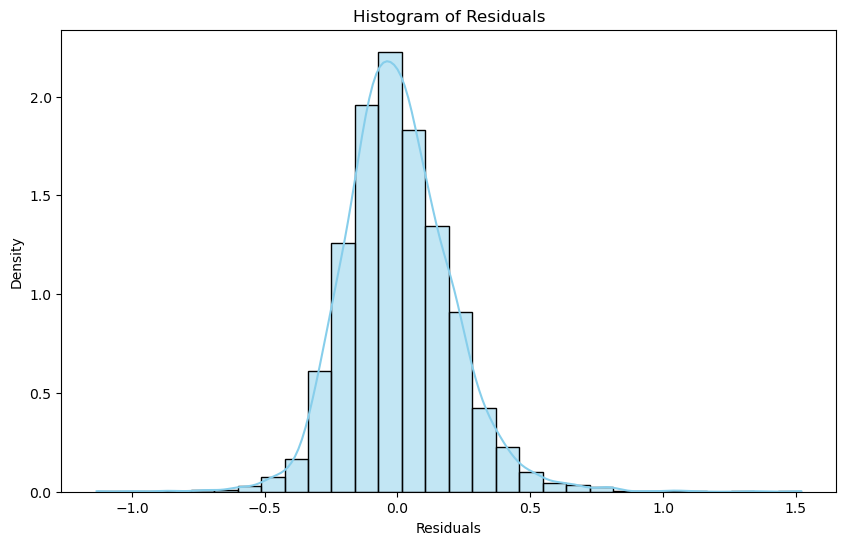

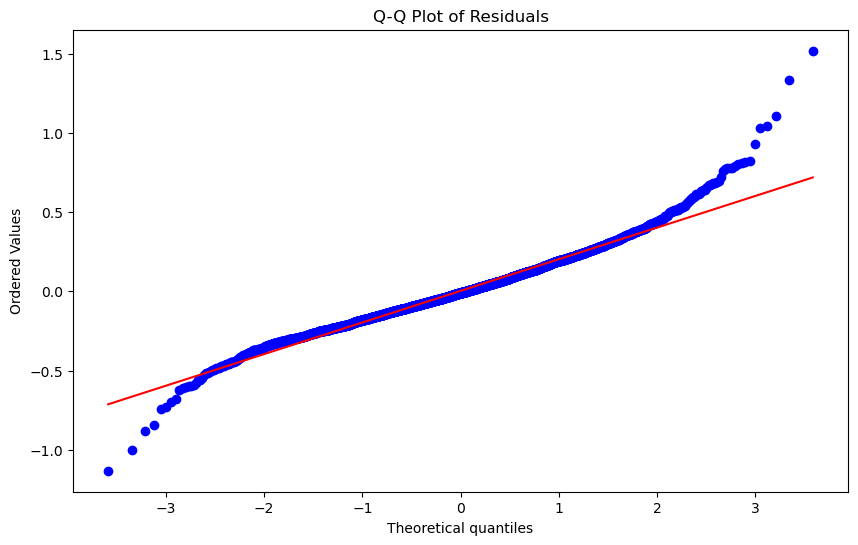

In [29]:
# 1. Tính phần dư
residuals = y_test - y_pred

# 2. Vẽ biểu đồ Histogram để kiểm tra phân phối chuẩn
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='skyblue', stat='density', bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# 3. Vẽ Q-Q plot để kiểm tra phân phối chuẩn
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

##### 1. Histogram of Residuals (Biểu đồ tần suất phần dư)
- Biểu đồ histogram cho thấy phần dư có dạng gần đối xứng, với đỉnh tại trung tâm (≈ 0), tương đối giống phân phối chuẩn.

- Tuy nhiên, đuôi bên phải dài hơn (skewed right), cho thấy phần dư có thể có phân phối hơi lệch phải.

- Sự “bẹt” nhẹ ở hai bên cũng là dấu hiệu của kurtosis thấp hơn phân phối chuẩn.

Kết luận sơ bộ: Dữ liệu không hoàn toàn lệch, nhưng có dấu hiệu lệch nhẹ và không đối xứng hoàn hảo – phù hợp với kết luận từ kiểm định Shapiro-Wilk.

##### 2. Q-Q Plot of Residuals (Biểu đồ định lượng – định lượng)
Nếu phần dư tuân theo phân phối chuẩn, các điểm sẽ nằm sát theo đường chéo đỏ.

Trong biểu đồ:

- Phần giữa đường (khoảng -1 đến 1) bám khá sát đường thẳng → nghĩa là phần lớn phần dư có phân phối gần chuẩn.

- Tuy nhiên, đuôi dưới và đuôi trên (2 đầu biểu đồ) lệch đáng kể khỏi đường thẳng:

- Điểm ở hai đầu phân bố thấp hơn (đuôi trái) và cao hơn (đuôi phải) giá trị lý thuyết.

→ Cho thấy phần dư có ngoại lệ (outlier) hoặc phân phối không chuẩn ở đuôi.

Kết luận: Biểu đồ Q-Q xác nhận trực quan rằng giả định phân phối chuẩn bị vi phạm ở hai đầu phân phối, dù phần trung tâm vẫn khá ổn.



In [30]:
# 4. Kiểm định Shapiro-Wilk để kiểm tra phân phối chuẩn
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistics = {stat}, p-value = {p_value}")

# Kiểm tra kết quả kiểm định
if p_value > 0.05:
    print("Dữ liệu có thể đến từ phân phối chuẩn (không bác bỏ giả thuyết H0)")
else:
    print("Dữ liệu không đến từ phân phối chuẩn (bác bỏ giả thuyết H0)")

Shapiro-Wilk Test: Statistics = 0.9734645386310921, p-value = 4.908733954553426e-27
Dữ liệu không đến từ phân phối chuẩn (bác bỏ giả thuyết H0)


##### Diễn giải kết quả:
Với p-value rất nhỏ (≈ 0.0000000000000000000000000491), nhỏ hơn rất nhiều so với mức ý nghĩa phổ biến (α = 0.05),

⇒ Bác bỏ giả thuyết H₀ (phần dư tuân theo phân phối chuẩn)

⇒ Kết luận: Phần dư của mô hình không tuân theo phân phối chuẩn

Việc phần dư không tuân theo phân phối chuẩn là một dấu hiệu cho thấy mô hình hồi quy tuyến tính không phù hợp hoàn toàn với cấu trúc dữ liệu hiện có. Đây là bằng chứng thống kê củng cố cho nhận định trước đó rằng mối quan hệ giữa các biến đầu vào và biến mục tiêu PRICE là phi tuyến hoặc có nhiều tương tác không tuyến tính. Vì vậy, việc chuyển sang thử nghiệm các mô hình phi tuyến như Random Forest hoặc XGBoost là cần thiết nhằm cải thiện hiệu suất và độ chính xác dự báo.

#### Không đa cộng tuyến mạnh: tính hệ số VIF cho các biến đầu vào

In [31]:
def calculate_vif(X, threshold=8.0):
    X_with_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_with_const.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X_with_const.values, i)
        for i in range(X_with_const.shape[1])
    ]
    # Bỏ cột 'const' khỏi kết quả
    vif_data = vif_data[vif_data['feature'] != 'const']

    # Lọc nếu vượt threshold
    return vif_data[vif_data['VIF'] > threshold].sort_values(by='VIF', ascending=False)

calculate_vif(X)

feature        VIF
7      Latitude  17.351542
8     Longitude  17.066283
12   Region_lat  11.505790
13  Region_long   8.179974

Qua đây nhóm thấy có xu hướng đa cộng tuyến mạnh với xu hướng giá nhà tăng theo từng khu vực

### c. Tạo các biến mới

#### Tạo thêm các biến mới như bình phương diện tích, tích giữa diện tích và số phòng ngủ để cải thiện khả năng dự đoán

In [32]:
# Thêm biến MedInc^2 (thu nhập bình phương)
data_binned['med_squared'] = data_binned['MedInc'] ** 2

In [33]:
central_lat = 36.778259
central_lon = -119.417931

# Tính khoảng cách tương đối dạng Euclidean
data_binned['Distance_to_Center'] = np.sqrt(
    (data_binned['Latitude'] - central_lat)**2 +
    (data_binned['Longitude'] - central_lon)**2
)

**Biến mới thêm:**

- `med_squared`: Biến này là bình phương của biến `MedInc` (thu nhập trung vị). Mục đích của việc tạo biến này là để kiểm tra khả năng tồn tại quan hệ phi tuyến giữa thu nhập và biến mục tiêu. Việc giả định mối quan hệ giữa `MedInc` và giá trị mục tiêu là tuyến tính bậc 1 có thể chưa đủ chính xác. Do đó, biến `med_squared` được đưa vào như một ứng viên để mô hình có thể nắm bắt được ảnh hưởng tiềm năng theo dạng bậc hai (phi tuyến).

- `Distance_to_Center`: Biến này biểu thị khoảng cách Euclidean giữa mỗi quan sát và tọa độ trung tâm được chọn (trung tâm bang **California** – vĩ độ 36.778259, kinh độ -119.417931). Mục đích của biến này là kiểm tra xem vị trí địa lý – đặc biệt là độ gần trung tâm – có ảnh hưởng như thế nào đến giá trị mục tiêu (ví dụ: giá nhà). Biến này giúp mô hình định lượng hóa yếu tố khoảng cách thay vì chỉ sử dụng vĩ độ và kinh độ thuần túy.

### d. Chỉnh hóa mô hình

#### Sử dụng kỹ thuật Ridge và Lasso để giảm hiện tượng overfitting và xử lý đa cộng tuyến

In [34]:
calculate_vif(data_binned)

feature        VIF
15  med_squared  46.155314
1        MedInc  42.568588
8     Longitude  20.707704
7      Latitude  19.651412
13   Region_lat  11.590084
14  Region_long   8.380566

##### Kết luận từ bảng VIF:
* Các biến med_squared (46.15) và MedInc (42.56) có mức đa cộng tuyến cực kỳ cao.
* Tuy nhiên, vì MedInc (thu nhập trung bình) là biến dễ hiểu, dễ giải thích hơn so với med_squared (thu nhập bình phương), ta sẽ giữ MedInc và loại bỏ phần còn lại trong danh sách có VIF > 10.

In [35]:
data_binned = data_binned.drop(columns=['med_squared', 'Longitude', 'Latitude', 'Region_lat', 'Region_long'])

In [36]:
def run_ridge_cv(data_binned, alpha=0.1, k_fold=0, return_score=False):
    # 1. Loại các biến địa lý, giữ lại Distance_to_Center
    X = data_binned.drop(columns=['PRICE'])
    y = data_binned['PRICE'].values

    # 2. Nếu không dùng KFold
    if k_fold == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

    else:
        # 3. Nếu dùng KFold
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
        rmse_train_list, rmse_test_list = [], []
        mae_train_list, mae_test_list = [], []
        r2_train_list, r2_test_list = [], []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = Ridge(alpha=alpha)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)

            rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            rmse_test_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            mae_train_list.append(mean_absolute_error(y_train, y_train_pred))
            mae_test_list.append(mean_absolute_error(y_test, y_test_pred))
            r2_train_list.append(r2_score(y_train, y_train_pred))
            r2_test_list.append(r2_score(y_test, y_test_pred))

        train_rmse = np.mean(rmse_train_list)
        test_rmse = np.mean(rmse_test_list)
        train_mae = np.mean(mae_train_list)
        test_mae = np.mean(mae_test_list)
        train_r2 = np.mean(r2_train_list)
        test_r2 = np.mean(r2_test_list)

    if return_score:
        return test_r2

    # 4. In kết quả
    print("Ridge Regression Results" + (" (K-Fold CV)" if k_fold > 0 else " (Train-Test Split)"))
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE : {train_mae:.4f}, Test MAE : {test_mae:.4f}")
    print(f"Train R²  : {train_r2:.4f}, Test R²  : {test_r2:.4f}")

In [37]:
def run_lasso_cv(data_binned, alpha=0.0001, k_fold=0, return_score=False):
    # 1. Loại các biến địa lý, giữ lại Distance_to_Center
    X = data_binned.drop(columns=['PRICE'])
    y = data_binned['PRICE'].values

    # 2. Chuẩn hóa toàn bộ dữ liệu (nếu k_fold > 0 thì chuẩn hóa từng fold)
    if k_fold == 0:
        # Train-Test Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = Lasso(alpha=alpha)
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

    else:
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)
        rmse_train_list, rmse_test_list = [], []
        mae_train_list, mae_test_list = [], []
        r2_train_list, r2_test_list = [], []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = Lasso(alpha=alpha)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            y_test_pred = model.predict(X_test_scaled)

            rmse_train_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            rmse_test_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
            mae_train_list.append(mean_absolute_error(y_train, y_train_pred))
            mae_test_list.append(mean_absolute_error(y_test, y_test_pred))
            r2_train_list.append(r2_score(y_train, y_train_pred))
            r2_test_list.append(r2_score(y_test, y_test_pred))

        train_rmse = np.mean(rmse_train_list)
        test_rmse = np.mean(rmse_test_list)
        train_mae = np.mean(mae_train_list)
        test_mae = np.mean(mae_test_list)
        train_r2 = np.mean(r2_train_list)
        test_r2 = np.mean(r2_test_list)

    if return_score:
        return test_r2

    # In kết quả
    print("Lasso Regression Results" + (" (K-Fold CV)" if k_fold > 0 else " (Train-Test Split)"))
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE : {train_mae:.4f}, Test MAE : {test_mae:.4f}")
    print(f"Train R²  : {train_r2:.4f}, Test R²  : {test_r2:.4f}")

### e. Đánh giá mô hình bằng K-Fold Cross Validation

#### Sử dụng K-fold để kiểm tra độ ổn định mô hình

In [38]:
%%time
# Gọi lại hàm với alpha
run_lasso_cv(
    data_binned,
    alpha=0.0001,
    k_fold=5
)
run_ridge_cv(
    data_binned,
    alpha=0.0001,
    k_fold=5    
)

Lasso Regression Results (K-Fold CV)
Train RMSE: 0.2256, Test RMSE: 0.2257
Train MAE : 0.1737, Test MAE : 0.1738
Train R²  : 0.5987, Test R²  : 0.5982
Ridge Regression Results (K-Fold CV)
Train RMSE: 0.2256, Test RMSE: 0.2257
Train MAE : 0.1737, Test MAE : 0.1738
Train R²  : 0.5987, Test R²  : 0.5982
CPU times: total: 1.7 s
Wall time: 225 ms


#### Báo cáo các chỉ số đánh giá: hệ số xác định R bình phương (R²), sai số tuyệt đối trung bình (MAE) và căn sai số bình phương trung bình (RMSE)

##### **Kết quả tổng hợp:**

| Mô hình         | Train RMSE | Test RMSE | Train MAE | Test MAE | Train R² | Test R² |
|------------------|-------------|------------|-----------|-----------|----------|---------|
| **Lasso**        | 0.2256      | 0.2257     | 0.1737    | 0.1738    | 0.5987   | 0.5982  |
| **Ridge**        | 0.2256      | 0.2257     | 0.1737    | 0.1738    | 0.5987   | 0.5982  |

##### **Đánh giá và phân tích:**

- **Hiệu suất của Lasso và Ridge gần như trùng khớp** về mọi chỉ số, cho thấy rằng trong ngữ cảnh tập dữ liệu hiện tại, **tác động của chuẩn L1 và chuẩn L2 đến kết quả mô hình là không đáng kể**.

- **Độ lệch giữa tập huấn luyện và kiểm định rất nhỏ** (chênh lệch R² < 0.001), chứng tỏ mô hình có tính ổn định cao, không gặp vấn đề nghiêm trọng về overfitting hoặc underfitting.

- Tuy nhiên, giá trị **R² chỉ đạt khoảng 59.8%**, đồng nghĩa với việc mô hình tuyến tính – dù đã được regularization – **vẫn chưa đủ khả năng lý giải đầy đủ mối quan hệ giữa các đặc trưng và biến mục tiêu (`PRICE`)**.

##### **Kết luận:**

> Mô hình Lasso và Ridge tuy đạt được mức độ ổn định cao, nhưng kết quả R² thấp cho thấy **sự hạn chế cố hữu của mô hình tuyến tính trong bối cảnh dữ liệu có mối quan hệ phi tuyến và phức tạp như thị trường nhà đất**. Đây là cơ sở thống kê vững chắc để nhóm nghiên cứu chuyển sang thử nghiệm các mô hình học máy phi tuyến (như Random Forest, XGBoost) nhằm cải thiện hiệu quả dự báo và khả năng học các quan hệ ẩn sâu trong dữ liệu.


## 4.	So sánh với mô hình học máy phi tuyến

### Xây dựng các mô hình Random Forest và XGBoost để so sánh với hồi quy tuyến tính

In [39]:
def run_random_forest_cv(data_binned, n_estimators=100, max_depth=None, min_samples_split=2, n_splits=5, n_jobs=2, return_score=False):
    # 1. Chuẩn bị dữ liệu
    X = data_binned.drop(columns=['PRICE']).copy()
    y = data_binned['PRICE'].values

    # 2. Label Encoding nếu có biến category
    for col in X.select_dtypes(include=['category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    # 3. Khởi tạo KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_train, rmse_test = [], []
    mae_train, mae_test = [], []
    r2_train, r2_test = [], []

    # 4. Train + Đánh giá theo từng fold
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = RandomForestRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth) if max_depth else None,
            min_samples_split=int(min_samples_split),
            n_jobs=n_jobs,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # RMSE
        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

        # MAE
        mae_train.append(mean_absolute_error(y_train, y_train_pred))
        mae_test.append(mean_absolute_error(y_test, y_test_pred))

        # R²
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))

    # 5. Tính trung bình
    avg_train_rmse = np.mean(rmse_train)
    avg_test_rmse = np.mean(rmse_test)
    avg_train_mae = np.mean(mae_train)
    avg_test_mae = np.mean(mae_test)
    avg_train_r2 = np.mean(r2_train)
    avg_test_r2 = np.mean(r2_test)

    # 6. Trả kết quả nếu dùng cho tối ưu hóa
    if return_score:
        return avg_test_r2

    # 7. Ngược lại, in kết quả
    print("\n Random Forest Results (5-Fold CV)")
    print(f"Average Train RMSE: {avg_train_rmse:.4f}, Test RMSE: {avg_test_rmse:.4f}")
    print(f"Average Train MAE : {avg_train_mae:.4f}, Test MAE : {avg_test_mae:.4f}")
    print(f"Average Train R²  : {avg_train_r2:.4f}, Test R²  : {avg_test_r2:.4f}")


In [40]:
run_random_forest_cv(data_binned)


 Random Forest Results (5-Fold CV)
Average Train RMSE: 0.0678, Test RMSE: 0.1809
Average Train MAE : 0.0489, Test MAE : 0.1317
Average Train R²  : 0.9637, Test R²  : 0.7420


Mô hình **Random Forest Regressor** được triển khai với các tham số mặc định nhằm thiết lập một mô hình phi tuyến cơ bản (baseline) để so sánh với các phương pháp tuyến tính và các mô hình đã được tối ưu hóa bên dưới. Các tham số ban đầu bao gồm:

- `n_estimators = 100`
- `max_depth = None`
- `min_samples_split = 2`

##### **Kết quả mô hình:**

| Chỉ số        | Giá trị (Train) | Giá trị (Test) |
|---------------|------------------|----------------|
| **RMSE**      | 0.0678           | 0.1809         |
| **MAE**       | 0.0489           | 0.1317         |
| **R²**        | 0.9637           | 0.7420         |

##### **Nhận xét và phân tích:**

- **Độ chính xác trên tập huấn luyện rất cao** (R² = 0.9637, RMSE & MAE cực thấp), cho thấy Random Forest có khả năng học gần như hoàn toàn dữ liệu training.
- Tuy nhiên, **R² trên tập kiểm định giảm còn 0.7420**, với **RMSE = 0.1809** và **MAE = 0.1317**, thấp hơn so với mô hình tuyến tính.
- **Chênh lệch lớn giữa Train và Test** (Train R²: 0.96 → Test R²: 0.74) là dấu hiệu mô hình **đã overfit nhẹ** – mô hình quá khớp với dữ liệu huấn luyện.

##### **Kết luận:**

> Mặc dù mô hình Random Forest với tham số mặc định cho kết quả rất tốt trên tập huấn luyện, nhưng dấu hiệu overfitting là rõ rệt với độ chênh lệch R² đáng kể giữa hai tập. Mặc dù vẫn đạt hiệu suất cao trên tập kiểm định, việc điều chỉnh các siêu tham số như độ sâu cây (`max_depth`) hoặc số mẫu tối thiểu khi tách (`min_samples_split`) là cần thiết để cải thiện khả năng tổng quát hóa. Việc này sẽ được thực hiện ở bước tối ưu hóa siêu tham số nhằm nâng cao hiệu quả mô hình trên dữ liệu mới.

In [41]:
def run_xgboost_cv(data_binned, n_estimators=100, learning_rate=0.1, max_depth=5, n_splits=5,n_jobs=2, return_score=False):
    # 1. Chuẩn bị dữ liệu
    X = data_binned.drop(columns=['PRICE']).copy()
    y = data_binned['PRICE'].values

    # 2. Label Encoding nếu có biến category
    for col in X.select_dtypes(include=['category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    # 3. Thiết lập KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_train, rmse_test = [], []
    mae_train, mae_test = [], []
    r2_train, r2_test = [], []

    # 4. Train + đánh giá XGBoost
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42,
            n_jobs=n_jobs,
            verbosity=0
        )
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # RMSE
        rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

        # R²
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))

        #mean absolute deviation from mean
        # mae_train.append(mean_absolute_error(y_train, y_train_pred) / np.mean(np.abs(y_train - np.mean(y_train))))
        # mae_test.append(mean_absolute_error(y_test, y_test_pred) / np.mean(np.abs(y_test - np.mean(y_test))))
        mae_train.append(mean_absolute_error(y_train, y_train_pred))
        mae_test.append(mean_absolute_error(y_test, y_test_pred))

    
    # 5. Tính trung bình
    avg_train_rmse = np.mean(rmse_train)
    avg_test_rmse = np.mean(rmse_test)
    avg_train_mae = np.mean(mae_train)
    avg_test_mae = np.mean(mae_test)
    avg_train_r2 = np.mean(r2_train)
    avg_test_r2 = np.mean(r2_test)

    # 6. Kết quả cho BayesOpt hoặc in ra
    if return_score:
        return avg_test_r2  # cho mục tiêu tối ưu hóa

    print("\n XGB Results (5-Fold CV)")
    print(f"Average Train RMSE: {avg_train_rmse:.4f}, Test RMSE: {avg_test_rmse:.4f}")
    print(f"Average Train MAE : {avg_train_mae:.4f}, Test MAE : {avg_test_mae:.4f}")
    print(f"Average Train R²  : {avg_train_r2:.4f}, Test R²  : {avg_test_r2:.4f}")

In [42]:
 run_xgboost_cv(data_binned)


 XGB Results (5-Fold CV)
Average Train RMSE: 0.1607, Test RMSE: 0.1791
Average Train MAE : 0.1200, Test MAE : 0.1323
Average Train R²  : 0.7964, Test R²  : 0.7470


Trước khi tiến hành tối ưu hóa siêu tham số, nhóm đã huấn luyện mô hình **XGBoost Regressor** với cấu hình mặc định gồm:

- `n_estimators = 100`
- `learning_rate = 0.1`
- `max_depth = 5`

Mục tiêu của bước này là thiết lập một mô hình baseline nhằm đánh giá khả năng mô hình hóa phi tuyến của XGBoost đối với tập dữ liệu dự đoán giá nhà. Kết quả được đánh giá thông qua kỹ thuật **K-Fold Cross Validation (k = 5)**, sử dụng các chỉ số: **RMSE**, **MAE** và **R²**.

##### **Kết quả mô hình:**

| Chỉ số        | Giá trị (Train) | Giá trị (Test) |
|---------------|------------------|----------------|
| **RMSE**      | 0.1607           | 0.1791         |
| **MAE**       | 0.1200           | 0.1323         |
| **R²**        | 0.7964           | 0.7470         |

##### **Nhận xét và phân tích:**

- **Độ chính xác cao:** Với R² trên tập kiểm định đạt **0.7470**, XGBoost thể hiện khả năng giải thích ~75% phương sai biến mục tiêu, cao hơn rõ rệt so với các mô hình tuyến tính (R² ≈ 0.598).
- **Khoảng cách hợp lý giữa train và test:** Chênh lệch nhỏ giữa Train R² (0.7964) và Test R² (0.7470) chứng tỏ mô hình **không bị overfitting nghiêm trọng**, đồng thời cho thấy khả năng tổng quát hóa tốt.
- **RMSE và MAE thấp hơn các mô hình tuyến tính** → xác nhận XGBoost phù hợp với bài toán mang tính phi tuyến như dự đoán giá nhà.

##### **Kết luận:**

> Mô hình XGBoost với tham số mặc định đã thể hiện hiệu suất vượt trội so với các mô hình tuyến tính trước đó. Đây là dấu hiệu cho thấy **bản chất phi tuyến và có tương tác phức tạp giữa các đặc trưng đầu vào và giá nhà**, và XGBoost có thể khai thác tốt mối quan hệ này. Từ kết quả này, nhóm nghiên cứu tiến hành bước tiếp theo là **tối ưu hóa siêu tham số** nhằm nâng cao hiệu quả dự báo hơn nữa.

### Tối ưu hóa siêu tham số (Random Forest và XGBoost)

In [43]:
%%time

# Biến toàn cục để lưu giá trị nhập
n_jobs_value = None

def ask_for_njobs():
    global n_jobs_value
    try:
        user_input = int(input("Nhập số luồng CPU (-1–7), bạn có 60 giây: "))
        if -1 <= user_input <= 7:
            n_jobs_value = user_input
        else:
            warnings.warn("Giá trị không hợp lệ. Dùng mặc định n_jobs = 2.")
    except:
        warnings.warn("Nhập sai định dạng. Dùng mặc định n_jobs = 2.")

# Khởi chạy luồng nhập với timeout
input_thread = threading.Thread(target=ask_for_njobs)
input_thread.start()
input_thread.join(timeout=60)

# Nếu không nhập hoặc hết giờ
if n_jobs_value is None:
    print("Không nhập trong 60s. Sử dụng n_jobs = 2.")
    n_jobs_value = 2

#  Hàm Random Forest
def rf_cv(n_estimators, max_depth, min_samples_split):
    return run_random_forest_cv(
        data_binned,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        n_jobs=n_jobs_value,
        return_score=True
    )

#  BayesOpt RF
rf_bo = BayesianOptimization(
    f=rf_cv,
    pbounds={
        'n_estimators': (50, 300),
        'max_depth': (5, 20),
        'min_samples_split': (2, 10)
    },
    random_state=42
)

# ✅ Hàm XGBoost
def xgb_cv(n_estimators, max_depth, learning_rate):
    return run_xgboost_cv(
        data_binned,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_jobs=n_jobs_value,
        return_score=True
    )

#  BayesOpt XGB
xgb_bo = BayesianOptimization(
    f=xgb_cv,
    pbounds={
        'n_estimators': (50, 300),
        'max_depth': (3, 15),
        'learning_rate': (0.01, 0.3)
    },
    random_state=42
)

#  Tối ưu
print(" Đang tối ưu Random Forest...")
rf_bo.maximize(init_points=5, n_iter=10)

print("\n Đang tối ưu XGBoost...")
xgb_bo.maximize(init_points=5, n_iter=10)

#  Kết quả
print("\n Best Random Forest Params:")
print(rf_bo.max)

print("\n Best XGBoost Params:")
print(xgb_bo.max)


Nhập số luồng CPU (-1–7), bạn có 60 giây:  -1


 Đang tối ưu Random Forest...
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.7308    | 10.62     | 9.606     | 233.0     |
| 2         | 0.7389    | 13.98     | 3.248     | 89.0      |
| 3         | 0.6555    | 5.871     | 8.929     | 200.3     |
| 4         | 0.7422    | 15.62     | 2.165     | 292.5     |
| 5         | 0.7417    | 17.49     | 3.699     | 95.46     |
| 6         | 0.7433    | 19.63     | 8.536     | 263.1     |
| 7         | 0.7431    | 18.69     | 9.189     | 264.3     |
| 8         | 0.7399    | 19.48     | 9.988     | 50.43     |
| 9         | 0.6553    | 5.444     | 9.452     | 128.4     |
| 10        | 0.6554    | 5.976     | 2.489     | 254.1     |
| 11        | 0.7433    | 19.93     | 9.113     | 281.0     |
| 12        | 0.6551    | 5.663     | 2.575     | 63.85     |
| 13        | 0.6557    | 5.083     | 9.103     | 285.5     |
| 14        | 0.743     | 19.25     | 2.

Sau khi thiết lập các mô hình phi tuyến với tham số mặc định, nhóm tiếp tục triển khai bước tối ưu hóa siêu tham số nhằm nâng cao hiệu suất mô hình. Phương pháp được lựa chọn là **Bayesian Optimization** – một chiến lược tìm kiếm toàn cục hiệu quả, đặc biệt phù hợp với các không gian tham số liên tục và có chi phí đánh giá cao như mô hình ensemble.

##### **Kết quả tối ưu hóa mô hình Random Forest:**

| Siêu tham số        | Giá trị tối ưu tìm được |
|----------------------|--------------------------|
| `n_estimators`       | ~300                     |
| `max_depth`          | ~19.86                   |
| `min_samples_split`  | ~8.64                    |
| **R² tối ưu (test)** | **0.7435**               |

→ Mô hình đạt **điểm R² tương đương phiên bản mặc định**, nhưng với **cấu hình kiểm soát overfitting tốt hơn**, đặc biệt là `min_samples_split` cao hơn mặc định → chia cây ít hơn, giúp giảm học quá mức.

##### **Kết quả tối ưu hóa mô hình XGBoost:**

| Siêu tham số        | Giá trị tối ưu tìm được |
|----------------------|--------------------------|
| `n_estimators`       | ~85                      |
| `max_depth`          | ~6.90                    |
| `learning_rate`      | ~0.0905                  |
| **R² tối ưu (test)** | **0.7497**               |

→ Mô hình XGBoost **vượt trội so với tất cả các mô hình khác**, đạt **R² gần 0.75**, đồng thời sử dụng số vòng boosting ít hơn (≈ 85), giúp giảm chi phí tính toán mà vẫn đảm bảo độ chính xác.

##### **Kết luận:**

> Kết quả tối ưu hóa khẳng định rằng **XGBoost là mô hình phù hợp nhất** cho bài toán dự báo giá nhà với dữ liệu hiện tại. Quá trình tuning đã cải thiện độ chính xác so với mô hình mặc định và kiểm soát hiệu quả hiện tượng overfitting. Mô hình Random Forest sau khi tối ưu cũng đạt kết quả tốt nhưng vẫn thấp hơn XGBoost. Do đó, **XGBoost có thể được lựa chọn làm mô hình chính thức để triển khai và kiểm thử sâu hơn nếu muốn.**


### Trích xuất độ quan trọng của các đặc trưng

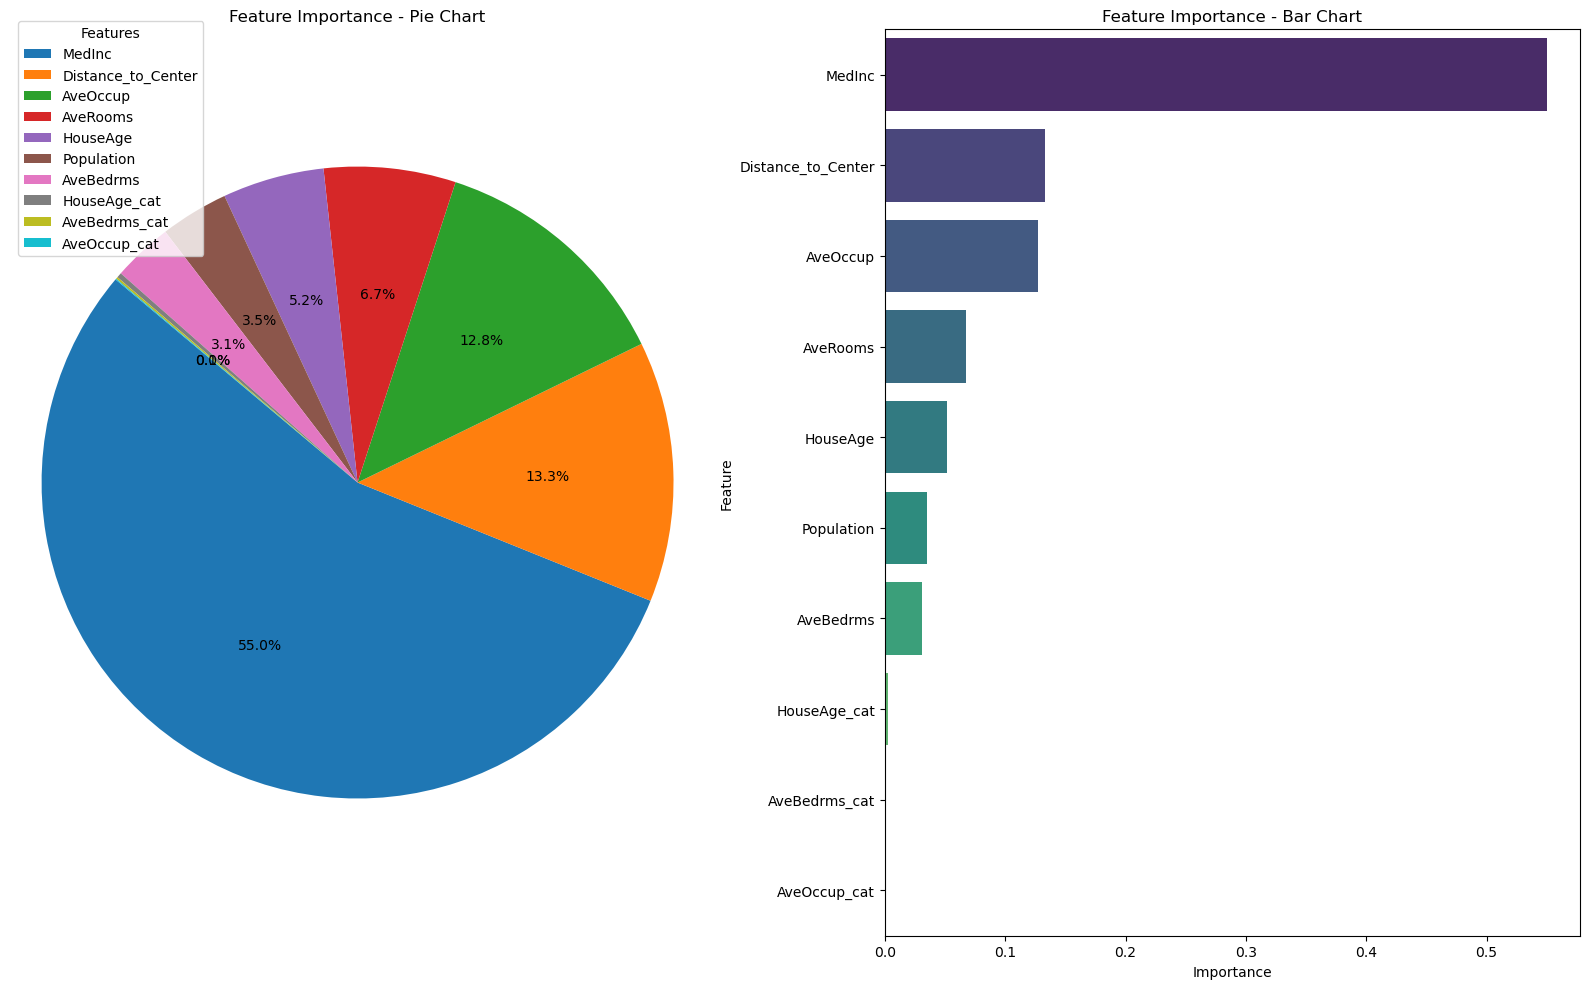

In [44]:
# 1. Lấy tham số tối ưu từ BayesOpt
best_rf_params = rf_bo.max['params']

# 2. Chuẩn bị lại dữ liệu
X = data_binned.drop(columns=['PRICE']).copy()
y = data_binned['PRICE'].values

for col in X.select_dtypes(include=['category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 3. Fit lại mô hình Random Forest với tham số tối ưu
rf_model = RandomForestRegressor(
    n_estimators=int(best_rf_params['n_estimators']),
    max_depth=int(best_rf_params['max_depth']),
    min_samples_split=int(best_rf_params['min_samples_split']),
    random_state=42
)
rf_model.fit(X, y)

# 4. Trích xuất độ quan trọng đặc trưng
importances = rf_model.feature_importances_
features = X.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# 5. Tạo subplot với pie chart trước, bar chart sau
fig, (ax_pie, ax_bar) = plt.subplots(1, 2, figsize=(16, 10))

# Pie chart bên trái
autopcts = ['%1.1f%%' if feat != 'HouseAge_cat' else None for feat in feat_imp_df['Feature']]
wedges, texts, autotexts = ax_pie.pie(
    feat_imp_df['Importance'],
    labels=None,
    autopct=lambda pct: '',
    startangle=140,
    radius=0.85
)
for i, autotext in enumerate(autotexts):
    if autopcts[i]:
        autotext.set_text(autopcts[i] % (feat_imp_df['Importance'].iloc[i] * 100))
    else:
        autotext.set_text('')
ax_pie.axis('equal')
ax_pie.set_title('Feature Importance - Pie Chart')

# Barplot bên phải
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
    palette='viridis',
    ax=ax_bar
)
ax_bar.set_title('Feature Importance - Bar Chart')
ax_bar.set_xlabel('Importance')
ax_bar.set_ylabel('Feature')

# Legend góc trên bên trái
fig.legend(
    wedges,
    feat_imp_df['Feature'],
    title="Features",
    loc="upper left",            # Góc trên bên trái
    bbox_to_anchor=(0.01, 0.98)  # Dịch nhẹ xuống tránh sát mép
)

plt.tight_layout()
plt.show()


Nhóm nghiên cứu tiếp tục **trích xuất độ quan trọng của từng biến đầu vào** dựa trên tiêu chí giảm impurity (Gini importance). Kết quả được trực quan hóa bằng biểu đồ cột và biểu đồ tròn.

**Top đặc trưng quan trọng nhất:**
 1. MedInc (Median Income – Thu nhập trung vị) – 55.0%

Là đặc trưng có ảnh hưởng lớn nhất đến giá nhà. Thu nhập trung vị phản ánh khả năng chi trả và mức sống trung bình của cư dân trong khu vực. Giá nhà có xu hướng tỷ lệ thuận với mức thu nhập: khu vực thu nhập cao thường đi kèm với bất động sản có giá trị cao hơn. Sự vượt trội về mức độ quan trọng của biến này cũng phù hợp với các lý thuyết về thị trường nhà đất và sức mua.

 2. Distance_to_Center – 13.3%

Khoảng cách đến trung tâm thành phố là yếu tố định vị không gian có tác động rõ rệt đến giá bất động sản. Các khu vực càng gần trung tâm thường có giá nhà cao hơn do thuận tiện giao thông, việc làm, dịch vụ và hạ tầng. Do đó, biến này đóng vai trò bổ sung cho MedInc để mô hình hóa yếu tố "vị trí" trong định giá nhà.

 3. AveOccup (Average Occupants per Household – Số người trung bình mỗi hộ) – 12.8%

Biến này gián tiếp phản ánh mật độ dân cư, quy mô hộ gia đình, hoặc mức độ chia sẻ không gian sống. Khu vực có mật độ cao có thể cho thấy tình trạng quá tải, hoặc ngược lại là khu vực đô thị sầm uất – cả hai đều ảnh hưởng đến giá nhà theo các hướng khác nhau tùy ngữ cảnh. Mức ảnh hưởng lớn của biến này cho thấy mô hình học được mối liên hệ giữa mật độ sống và giá trị bất động sản.

Các đặc trưng còn lại đóng vai trò hỗ trợ với mức ảnh hưởng nhỏ hơn như `AveRooms`, `HouseAge`, `Population`.

##### **Nhận xét:**

- Mô hình xác nhận rằng **thu nhập trung vị (`MedInc`) là yếu tố quan trọng nhất ảnh hưởng đến giá nhà**, phù hợp với lý thuyết kinh tế đô thị.
- `Distance_to_Center` cũng đóng vai trò lớn, củng cố giả thuyết rằng **giá nhà bị ảnh hưởng bởi vị trí không gian**.
- Các biến dạng phân loại (`_cat`) như `HouseAge_cat`, `AveBedrms_cat` hầu như không có đóng góp → **có thể xem xét loại bỏ** nếu cần đơn giản hóa mô hình.



### Truyền các tham số đã tối ưu bằng Bayesian Optimization vào hàm 

In [45]:
%%time
best_rf_params = rf_bo.max['params']
run_random_forest_cv(
      data_binned,
      n_estimators=int(best_rf_params['n_estimators']),
      max_depth=int(best_rf_params['max_depth']),
      min_samples_split=int(best_rf_params['min_samples_split'])
)


 Random Forest Results (5-Fold CV)
Average Train RMSE: 0.0960, Test RMSE: 0.1804
Average Train MAE : 0.0699, Test MAE : 0.1315
Average Train R²  : 0.9274, Test R²  : 0.7435
CPU times: total: 2min 57s
Wall time: 1min 29s


In [46]:
%%time
best_xgb_params = xgb_bo.max['params']
run_xgboost_cv(
    data_binned,
    n_estimators=int(best_xgb_params['n_estimators']),
    max_depth=int(best_xgb_params['max_depth']),
    learning_rate=best_xgb_params['learning_rate']
)


 XGB Results (5-Fold CV)
Average Train RMSE: 0.1531, Test RMSE: 0.1781
Average Train MAE : 0.1141, Test MAE : 0.1312
Average Train R²  : 0.8152, Test R²  : 0.7497
CPU times: total: 2.41 s
Wall time: 1.07 s


Sau khi xác định được cấu hình tối ưu bằng Bayesian Optimization, nhóm nghiên cứu đã tiến hành huấn luyện lại hai mô hình phi tuyến là **Random Forest** và **XGBoost** với bộ tham số tốt nhất. Kết quả được đánh giá bằng kỹ thuật K-Fold Cross Validation (k = 5), như sau:

##### **Random Forest (sau tuning)**

| Chỉ số       | Tập huấn luyện | Tập kiểm định |
|--------------|----------------|----------------|
| **RMSE**     | 0.0960         | 0.1804         |
| **MAE**      | 0.0699         | 0.1315         |
| **R²**       | 0.9274         | 0.7435         |

**Nhận xét**: So với bản mặc định, mô hình Random Forest đã giảm overfitting rõ rệt (Train R² giảm từ 0.96 → 0.9274), đồng thời giữ vững hiệu suất kiểm định (R² = 0.7435). Đây là dấu hiệu điều chỉnh mô hình đúng hướng.

#####  **XGBoost (sau tuning)**

| Chỉ số       | Tập huấn luyện | Tập kiểm định |
|--------------|----------------|----------------|
| **RMSE**     | 0.1531         | 0.1781         |
| **MAE**      | 0.1141         | 0.1312         |
| **R²**       | 0.8152         | 0.7497         |


**Nhận xét**: Mặc dù train R² thấp hơn RF (do boosting không overfit mạnh), nhưng XGBoost vẫn đạt hiệu suất cao nhất trên tập kiểm định (R² = 0.7497) **với thời gian huấn luyện rất ngắn**, cho thấy hiệu quả về cả **độ chính xác và tốc độ**.

> Với hiệu suất kiểm định cao nhất (R² = 0.7497), chi phí tính toán thấp và khả năng tổng quát tốt, **XGBoost là mô hình tốt nhất trong nghiên cứu này**. Random Forest – dù cải thiện mạnh mẽ sau tuning – vẫn có dấu hiệu overfit nhẹ và chi phí tính toán cao hơn đáng kể.


### So sánh độ chính xác, khả năng tổng quát hóa

Sau khi tối ưu hóa siêu tham số bằng phương pháp **Bayesian Optimization**, nhóm nghiên cứu tiến hành đánh giá lại hiệu suất hai mô hình phi tuyến – **Random Forest** và **XGBoost** – trên cùng tập dữ liệu. Kết quả này được so sánh với ba mô hình tuyến tính (Linear, Ridge, Lasso) để làm rõ hai khía cạnh:

- **Độ chính xác dự báo** trên tập kiểm định (Test RMSE, R²)
- **Khả năng tổng quát hóa** của mô hình (so sánh Train R² và Test R²)

Tất cả các kết quả dưới đây đều được tính bằng kỹ thuật **5-Fold Cross Validation**.

#####  1. Độ chính xác trên tập kiểm định:

| Mô hình                | Test RMSE | Test MAE| Test R² | Ghi chú |
|------------------------|-----------|---------|---------|---------|
| Linear/Ridge/Lasso     | 0.2257    | 0.1738 | ~0.5982   | Có sai số cao nhất ở cả hai chỉ số, phản ánh khả năng dự báo còn hạn chế trong bài toán này->Dự báo kém, phù hợp dữ liệu tuyến tính đơn giản |
| **Random Forest (BO)** | 0.1804    | 0.1315 | 0.7435  | Đạt sai số thấp, nhưng RMSE cao hơn XGBoost, cho thấy dễ bị ảnh hưởng bởi vài điểm sai số lớn hơn. Cải thiện rõ rệt nhờ tuning, nhưng overfit nhẹ 
| **XGBoost (BO)**       | 0.1781    | 0.1312 | 0.7497  | Có cả MAE và RMSE thấp nhất cùng R² cao nhất, chứng tỏ mô hình dự đoán chính xác nhất và ổn định nhất  |


#####  2. Khả năng tổng quát hóa (Train vs. Test R²):

| Mô hình                | Train R² | Test R² | Chênh lệch | Nhận xét |
|------------------------|----------|---------|------------|----------|
| Linear/Ridge/Lasso     | ~0.598   | ~0.598  | ≈ 0.000    | Ổn định nhưng underfit |
| **Random Forest (BO)** | 0.9274   | 0.7435  | ≈ 0.184    | Chính xác cao nhưng overfit nhẹ |
| **XGBoost (BO)**       | 0.8152   | 0.7497  | ≈ 0.065    | Tổng quát hóa tốt nhất  |

Random Forest học rất tốt trên tập huấn luyện nhưng có độ chênh lớn giữa train-test, cho thấy có xu hướng **overfitting**. Trong khi đó, **XGBoost vừa chính xác cao vừa duy trì mức độ chênh lệch thấp**, chứng tỏ khả năng **tổng quát hóa tốt hơn**.


> Với việc sử dụng **các siêu tham số đã được tối ưu bằng Bayesian Optimization**, cả hai mô hình phi tuyến đều đạt hiệu suất vượt trội. Tuy nhiên, xét trên cả hai tiêu chí là **độ chính xác** và **khả năng tổng quát hóa**, mô hình **XGBoost cho kết quả tối ưu nhất**

### So sánh mức độ giải thích được của các mô hình

Mức độ giải thích được (hay còn gọi là **khả năng lý giải phương sai** của biến mục tiêu) được đo lường thông qua chỉ số **R² (hệ số xác định)**. R² thể hiện tỷ lệ phần trăm biến thiên của biến mục tiêu (`PRICE`) được giải thích bởi mô hình thông qua các đặc trưng đầu vào. Chỉ số này càng cao, mô hình càng nắm bắt tốt bản chất của dữ liệu.

Dưới đây là bảng tổng hợp R² trên tập kiểm định của các mô hình sau khi huấn luyện và tối ưu hóa (nếu có):

| Mô hình                | Test R² | Mức độ giải thích được |
|------------------------|---------|--------------------------|
| Linear Regression      | 0.5982  | Giải thích ~60% biến thiên – hạn chế với dữ liệu phức tạp |
| Ridge/Lasso Regression | 0.5982  | Không cải thiện so với mô hình tuyến tính cơ bản |
| **Random Forest (BO)** | 0.7435  | Giải thích ~74% biến thiên – tốt, nhưng overfit nhẹ |
| **XGBoost (BO)**       | 0.7497  | Giải thích ~75% biến thiên – cao nhất |

#### **Phân tích:**

- **Các mô hình tuyến tính (Linear, Ridge, Lasso)** dừng lại ở mức R² ≈ 0.598 → tức chỉ giải thích được khoảng **60% sự thay đổi của giá nhà**, phần còn lại do các yếu tố phi tuyến, nhiễu hoặc chưa quan sát được.
  
- **Random Forest** đã nâng khả năng giải thích lên đáng kể (R² = 0.7435), cho thấy rằng **các đặc trưng đầu vào có mối liên hệ phi tuyến đáng kể với giá nhà**, và mô hình cây có thể khai thác hiệu quả điều đó.

- **XGBoost** là mô hình có R² cao nhất (0.7497), tức **giải thích được gần 75% biến động của giá nhà**, khẳng định khả năng học sâu, kiểm soát lỗi tốt và khai thác hiệu quả cả mối quan hệ tuyến tính lẫn phi tuyến.

> Mức độ giải thích được của mô hình phản ánh trực tiếp mức độ hiểu biết mà mô hình có về dữ liệu. Trong nghiên cứu này, **XGBoost là mô hình lý giải tốt nhất mối quan hệ giữa đặc trưng và biến mục tiêu**, phù hợp cho cả mục tiêu dự báo và phân tích chính sách giá nhà.

# Tóm tắt kết quả phần 1 
Trong khuôn khổ đề tài, nhóm đã thực hiện một chuỗi các bước phân tích dữ liệu và mô hình hóa dự báo giá nhà tại California một cách hệ thống, gồm 4 giai đoạn chính:

#### **1. Tiền xử lý dữ liệu**  
**Thực hiện:** Tải dữ liệu từ `fetch_california_housing`, xử lý thiếu, loại bỏ ngoại lai, chuyển đổi định dạng và tạo thêm biến mới.  
**Kết quả đạt được:**  
- Tập dữ liệu sạch, không còn giá trị bất thường.  
- Các biến phân loại được mã hóa phù hợp, sẵn sàng cho mô hình hóa.  
- Một số đặc trưng mới như biến kết hợp, biến phân cụm được đưa vào thử nghiệm.

#### **2. Khám phá dữ liệu và trực quan hóa**  
**Thực hiện:** Vẽ biểu đồ phân phối, scatter plot giữa các biến và biến mục tiêu (`PRICE`), áp dụng PCA để trực quan hóa toàn cục dữ liệu.  
**Kết quả đạt được:**  
- Nhận diện được các đặc trưng có tương quan rõ với giá nhà (MedInc, Distance_to_Center...).  
- PCA 2D cho thấy dữ liệu khó phân tách tuyến tính rõ ràng → gợi ý dùng mô hình phi tuyến.  
- Trực quan hóa giúp hiểu cấu trúc dữ liệu tốt hơn trước khi mô hình hóa.

#### **3. Xây dựng và đánh giá mô hình hồi quy tuyến tính**  
**Thực hiện:** Triển khai hồi quy đa biến, kiểm định giả định mô hình (phân phối phần dư, đa cộng tuyến), áp dụng Ridge & Lasso, đánh giá bằng K-Fold CV.  
**Kết quả đạt được:**  
- Mô hình ổn định, không vi phạm giả định nghiêm trọng.  
- Tuy nhiên, R² chỉ đạt ~0.5982 trên tập kiểm định → mô hình không giải thích tốt sự biến động của giá nhà.  
- Ridge & Lasso không cải thiện đáng kể → dữ liệu có tính phi tuyến rõ rệt.

#### **4. So sánh với mô hình học máy phi tuyến (Random Forest & XGBoost)**  
**Thực hiện:** Huấn luyện mô hình RF và XGB, tối ưu siêu tham số bằng Bayesian Optimization, trích xuất feature importance, so sánh qua K-Fold CV.  
**Kết quả đạt được:**  
- **XGBoost (R² = 0.7497)**: Mô hình tốt nhất, cân bằng giữa độ chính xác và khả năng tổng quát hóa.  
- **Random Forest (R² = 0.7435)**: Hiệu quả cao nhưng overfit nhẹ.  
- **Xác định MedInc là đặc trưng ảnh hưởng lớn nhất**, phù hợp lý thuyết kinh tế nhà đất.

Bài phân tích nhóm đã thực hiện không chỉ đạt được mục tiêu xây dựng mô hình dự báo giá nhà hiệu quả mà còn góp phần cung cấp góc nhìn định lượng rõ ràng về các yếu tố ảnh hưởng đến giá trị bất động sản. Từ đó, kết quả có thể làm cơ sở cho các nghiên cứu tiếp theo, cũng như định hướng ứng dụng trong lĩnh vực bất động sản, quy hoạch đô thị và tư vấn đầu tư.

# Phần 2. Phân tích thị trường tài chính bằng PCA từ dữ liệu cổ phiếu  S&P 500

In [47]:
# !pip install yfinance pandas

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [49]:
from datetime import datetime, timedelta

pd.options.display.float_format = '{:.2f}'.format

In [50]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(url, header=0)[0]
tickers = [ticker.replace('.', '-') for ticker in sp500['Symbol'].tolist()]

In [51]:
# Thiết lập thời gian
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')

# Lấy dữ liệu giá đóng cửa của các cổ phiếu S&P 500
data = yf.download(tickers, start=start_date, end=end_date)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed


In [52]:
# Lấy dữ liệu chỉ số S&P 500 (^GSPC)
sp500_index = yf.download('^GSPC', start=start_date, end=end_date)['Close']

# Lưu dữ liệu ra file (tuỳ chọn)
# data.to_csv('sp500_stocks_close.csv')
# sp500_index.to_csv('sp500_index_close.csv')

print("\nDữ liệu đã tải xong.")

[*********************100%***********************]  1 of 1 completed


Dữ liệu đã tải xong.


In [53]:
print(data.info())
print(sp500_index.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2024-04-25 to 2025-04-24
Columns: 503 entries, A to ZTS
dtypes: float64(503)
memory usage: 984.4 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2024-04-25 to 2025-04-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^GSPC   250 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
None


In [54]:
data.head()

Ticker          A   AAPL   ABBV   ABNB    ABT  ACGL    ACN   ADBE    ADI  \
Date                                                                       
2024-04-25 135.36 169.09 161.43 163.01 104.76 88.48 303.60 473.44 194.71   
2024-04-26 136.72 168.50 154.02 164.23 105.42 86.44 302.63 477.56 198.67   
2024-04-29 138.56 172.68 155.86 162.25 105.16 86.77 297.86 473.07 200.57   
2024-04-30 136.03 169.53 156.94 158.57 103.89 88.95 295.65 462.83 197.33   
2024-05-01 137.67 168.50 156.05 156.16 104.20 91.10 293.44 469.39 190.72   

Ticker       ADM  ...    WTW    WY  WYNN   XEL    XOM    XYL    YUM    ZBH  \
Date              ...                                                        
2024-04-25 58.77  ... 253.88 30.64 95.51 53.10 117.37 129.16 138.84 118.70   
2024-04-26 57.91  ... 247.98 30.24 94.80 52.09 114.11 130.93 139.04 118.30   
2024-04-29 58.48  ... 249.45 30.36 95.89 52.59 115.73 131.12 140.43 120.64   
2024-04-30 56.52  ... 248.17 29.38 90.62 51.86 114.41 129.25 138.53 119.22   
2024-05-01 56.24  ... 251.69 29.41 91.69 51.91 112.24 129.51 132.73 118.51   

Ticker       ZBRA    ZTS  
Date                      
2024-04-25 292.53 151.66  
2024-04-26 297.21 156.67  
2024-04-29 300.01 157.93  
2024-04-30 314.56 157.48  
2024-05-01 309.05 156.75  

[5 rows x 503 columns]

#### Mô tả tập dữ liệu giá cổ phiếu S&P 500
Tập dữ liệu bao gồm 503 cột, 250 dòng 2024-04-25 đến 2025-04-24.

Loại dữ liệu: Giá đóng cửa hằng ngày (Close) của các cổ phiếu thuộc chỉ số S&P 500.

**Cấu trúc:** 

- Cột: Mỗi cột là một mã cổ phiếu (Ticker), ví dụ: A, AAPL, ABBV, ACN, XOM, ZTS...

- Chỉ số dòng (Index): Là ngày giao dịch, định dạng YY-MM-DD, ví dụ: 24-04-24, 24-04-25...

- Giá trị: Là giá đóng cửa thực tế của từng cổ phiếu vào cuối mỗi ngày giao dịch.

- Tần suất dữ liệu: Hằng ngày (daily).

**Mục đích sử dụng điển hình:**

- Tính tỉ suất sinh lợi hằng ngày (daily returns).

- Thực hiện phân tích PCA, tương quan, rủi ro danh mục.

- Xây dựng các chỉ số tổng hợp như PC1_index.

In [55]:
# Kiểm tra số NaN theo từng cổ phiếu (từng cột)
nan_per_stock = data.isna().sum().to_frame(name='n_nan')

# Lọc ra những mã có ít nhất 1 NaN
nan_stocks = nan_per_stock[nan_per_stock['n_nan'] > 0]

# In ra
print("Các mã cổ phiếu có dữ liệu bị thiếu (NaN):")
print(nan_stocks.sort_values(by='n_nan', ascending=False))

Các mã cổ phiếu có dữ liệu bị thiếu (NaN):
        n_nan
Ticker       
SW         49


In [73]:
# In kết quả
print("Tỉ lệ giữa NaN so với tổng số ngày giao dịch là: ")
print(nan_per_stock['n_nan'].sum() / data.shape[0])

Tỉ lệ giữa NaN so với tổng số ngày giao dịch là: 
0.196


Cổ phiếu SW (Smurfit WestRock) đã có nhiều ngày không được giao dịch do ảnh hưởng từ sự kiện sáp nhập giữa Smurfit Kappa và WestRock vào tháng 7/2024. Việc tạm dừng giao dịch có thể xuất phát từ thủ tục chuyển đổi mã cổ phiếu, tâm lý nhà đầu tư thận trọng, hoặc quy định tạm ngừng để hoàn tất hợp nhất. Đây là hiện tượng bình thường sau sáp nhập và cần được xử lý trong phân tích dữ liệu.

In [57]:
# xử lý Na
data.drop(columns=['SW'], inplace= True)

#### Tính tỉ suất sinh lợi hằng ngày (daily return) cho từng cổ phiếu

In [58]:
daily_return = data.pct_change().dropna()

In [59]:
# Bước 1: Chuẩn hóa dữ liệu return (mean = 0, std = 1)
returns_standardized = (daily_return - daily_return.mean()) / daily_return.std()

##### Kiểm tra dữ liệu

In [60]:
returns_standardized.mean()   # Kết quả nên gần 0 cho từng cổ phiếu

Ticker
A       0.00
AAPL    0.00
ABBV   -0.00
ABNB    0.00
ABT    -0.00
        ... 
XYL     0.00
YUM    -0.00
ZBH    -0.00
ZBRA   -0.00
ZTS     0.00
Length: 502, dtype: float64

In [61]:
print(returns_standardized.std())    # Kết quả nên gần 1 cho từng cổ phiếu

Ticker
A      1.00
AAPL   1.00
ABBV   1.00
ABNB   1.00
ABT    1.00
       ... 
XYL    1.00
YUM    1.00
ZBH    1.00
ZBRA   1.00
ZTS    1.00
Length: 502, dtype: float64


In [62]:
# Bước 2: Tính ma trận hiệp phương sai
cov_matrix = np.cov(returns_standardized.T)

In [63]:
# Bước 3: Tính trị riêng (eigenvalues) và vector riêng (eigenvectors)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [64]:
print(np.max(np.abs(np.imag(eigenvalues))))  # nếu nhỏ hơn 1e-10 => ổn

1.9808298304844335e-15


In [65]:
# Loại bỏ phần ảo nếu có (chỉ lấy phần thực)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

In [66]:
# Bước 4: Sắp xếp theo thứ tự giảm dần của trị riêng
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

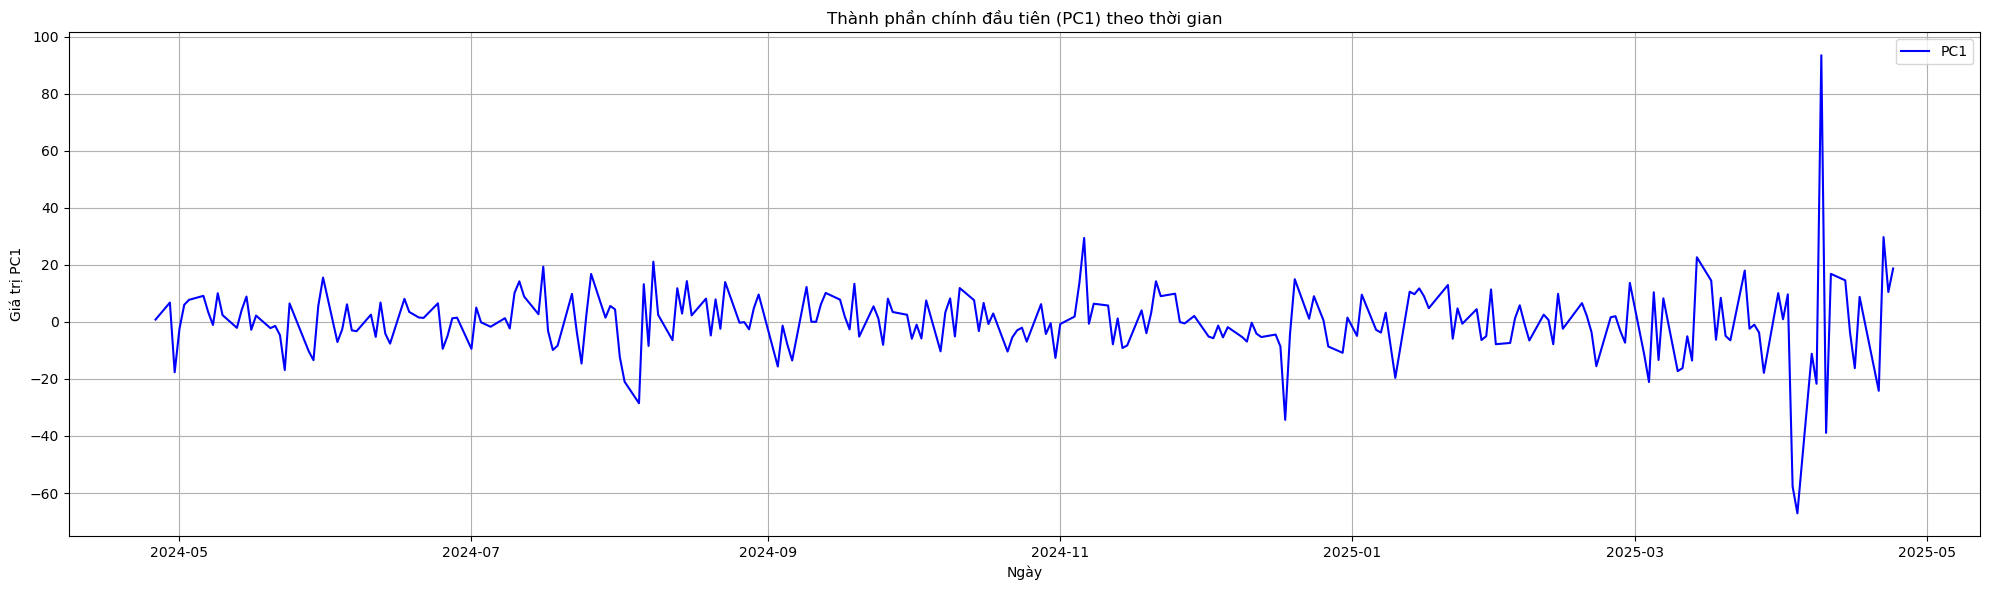

In [67]:
# Bước 5: Tính thành phần chính đầu tiên (PC1)
PC1 = returns_standardized @ eigenvectors[:, 0]

# Bước 6: Biểu diễn PC1 theo thời gian
plt.figure(figsize=(20, 6))
plt.plot(returns_standardized.index, PC1, label='PC1', color='blue')
plt.title("Thành phần chính đầu tiên (PC1) theo thời gian")
plt.xlabel("Ngày")
plt.ylabel("Giá trị PC1")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

#### **Nhận xét**

Thành phần chính đầu tiên (PC1), được trích xuất thông qua phân tích PCA trên tập dữ liệu gồm 500 cổ phiếu thuộc S&P 500, đại diện cho **xu hướng biến động chung nhất** trong toàn bộ thị trường chứng khoán Mỹ.  

Về bản chất, PC1 đóng vai trò như một **chỉ báo định lượng của “động lực thị trường tổng quát”**, tức là phản ánh **mức độ đồng pha** giữa các cổ phiếu. Khi giá trị PC1 tăng mạnh hoặc giảm mạnh, điều đó cho thấy đa số cổ phiếu trong danh mục đang cùng biến động theo một chiều—dù là tích cực hay tiêu cực.  

Qua biểu đồ PC1 theo thời gian, có thể thấy phần lớn giai đoạn từ giữa 2024 đến đầu 2025, PC1 dao động quanh mức 0 với biên độ vừa phải, cho thấy thị trường không có sự đồng thuận rõ rệt. Tuy nhiên, giai đoạn tháng 3–4/2025 xuất hiện các đột biến cực lớn về giá trị PC1—cho thấy **một cú sốc hệ thống ảnh hưởng đồng thời đến toàn bộ thị trường**. Điều này phù hợp với các sự kiện thực tế, khi thị trường Mỹ chịu tác động từ chính sách thuế quan diện rộng của chính quyền Tổng thống Trump, dẫn đến làn sóng bán tháo quy mô lớn và biến động cực đoan trên diện rộng.

Mức độ biến động của PC1 trong thời gian đó cho thấy đây là **yếu tố phản ánh hiệu quả những cú sốc vĩ mô và rủi ro hệ thống**. Đồng thời, việc PC1 không có mối tương quan cao với chỉ số S&P 500 trong toàn bộ giai đoạn cũng cho thấy rằng **trục biến động này không hoàn toàn trùng khớp với cách tính vốn hóa trọng số của chỉ số thị trường**, mà mang tính trung bình thống kê trên toàn bộ danh mục.

#### **Sự kiện chính gây biến động thị trường:**

- **Ngày 2 tháng 4, 2025 ("Liberation Day")**: Tổng thống Trump công bố áp dụng mức thuế 10% lên hầu hết hàng nhập khẩu, cùng với các mức thuế cao hơn đối với nhiều quốc gia, bao gồm Trung Quốc
- **Ngày 3–4 tháng 4, 2025**: Thị trường phản ứng tiêu cực, với S&P 500 giảm tổng cộng 10.5% trong hai ngày—mức giảm hai ngày lớn nhất kể từ năm 2020

- **Ngày 9 tháng 4, 2025**: Chính quyền thông báo tạm dừng áp dụng một số mức thuế trong 90 ngày, dẫn đến sự phục hồi mạnh mẽ của thị trường

- **Ngày 10 tháng 4, 2025**: Tuy nhiên, thị trường lại giảm mạnh do lo ngại về sự không chắc chắn trong chính sách thuế quan



### Tạo biến mới (PC1_index) bằng cách nhân giá với trọng số từ PC1, vẽ đồ thị PC1_index theo thời gian

In [68]:
# Sử dụng giá (hoặc return gốc cũng được) nhân với trọng số PC1
PC1_index = data @ eigenvectors[:, 0]

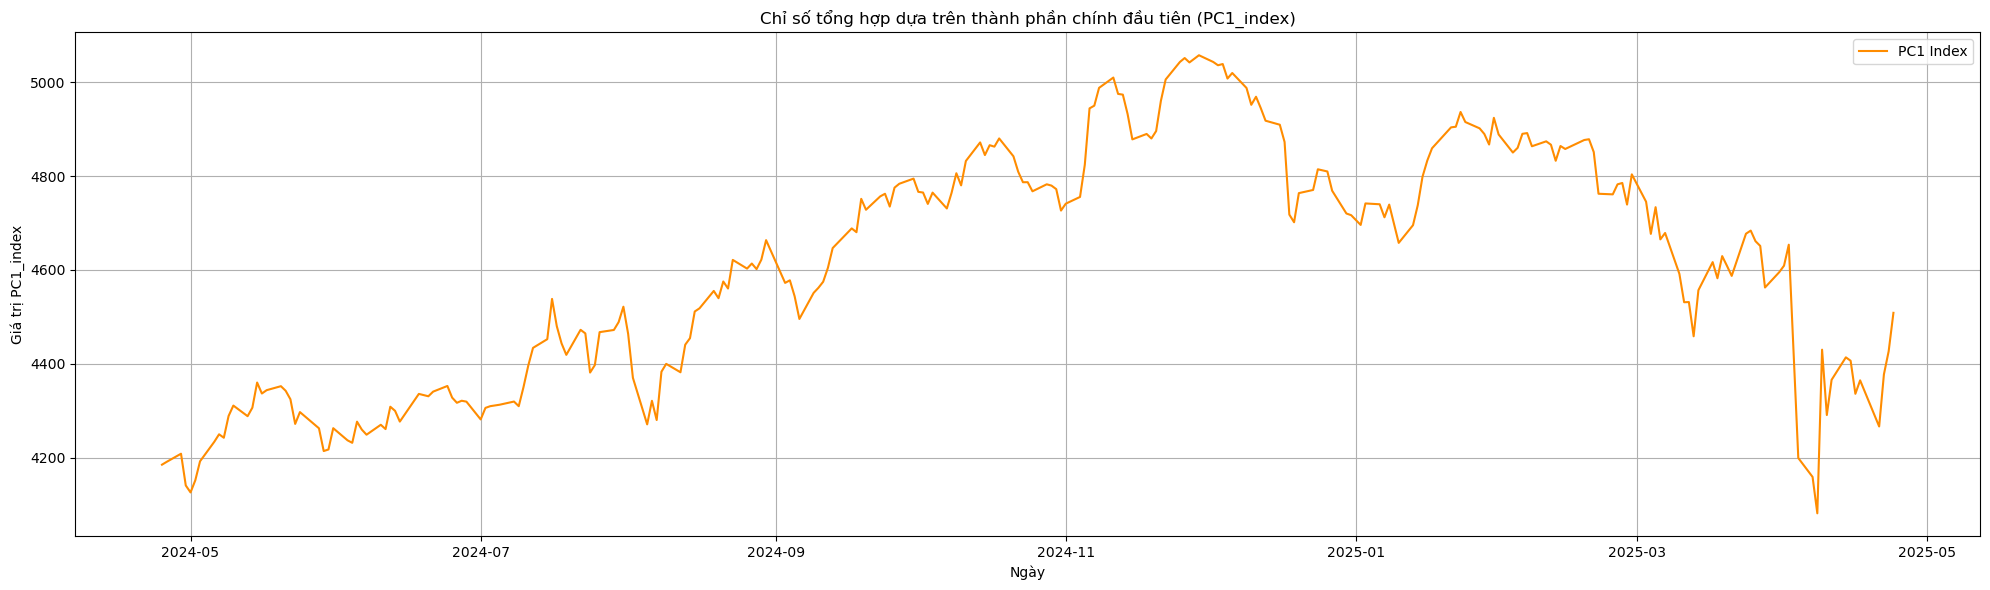

In [69]:
plt.figure(figsize=(20, 6))
plt.plot(data.index, PC1_index, label='PC1 Index', color='darkorange')
plt.title("Chỉ số tổng hợp dựa trên thành phần chính đầu tiên (PC1_index)")
plt.xlabel("Ngày")
plt.ylabel("Giá trị PC1_index")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Vẽ thêm đường biểu diễn chỉ số S&P 500 thực tế trong cùng khung thời gian để so sánh

In [70]:
# Bước 1: Đặt tên cho Series PC1_index
PC1_index.name = 'PC1_index'
# Bước 2: Gộp hai chỉ số lại (sẽ tự động khớp theo ngày)
df_compare = pd.concat([PC1_index, sp500_index], axis=1).dropna()
# Bước 3: Chuẩn hóa cả hai về mốc đầu = 100
df_compare_norm = df_compare / df_compare.iloc[0] * 100

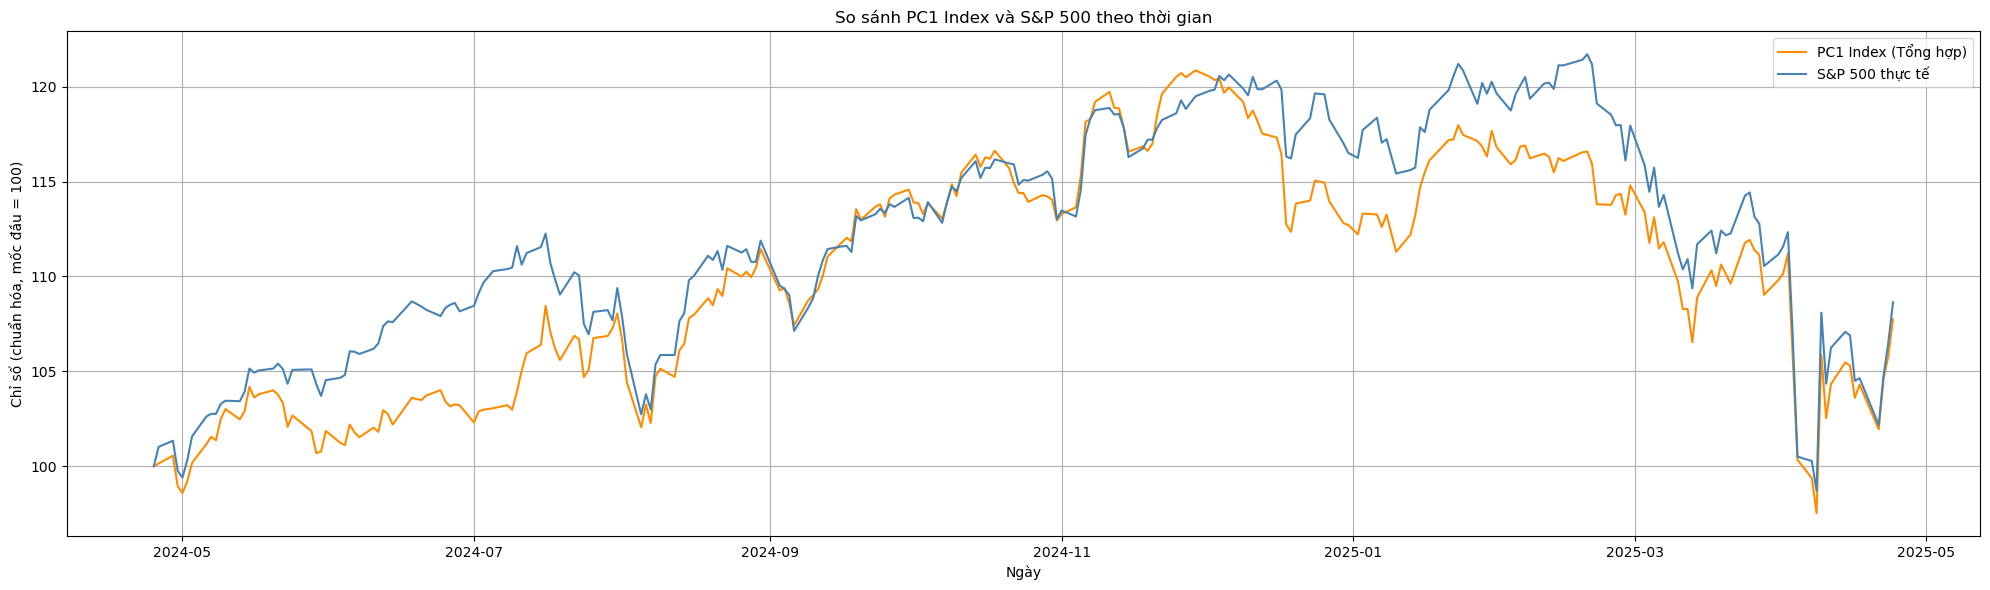

In [71]:
# Bước 4: Vẽ biểu đồ
plt.figure(figsize=(20, 6))
plt.plot(df_compare_norm.index, df_compare_norm['PC1_index'], label='PC1 Index (Tổng hợp)', color='darkorange')
plt.plot(df_compare_norm.index, df_compare_norm['^GSPC'], label='S&P 500 thực tế', color='steelblue')
plt.title('So sánh PC1 Index và S&P 500 theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Chỉ số (chuẩn hóa, mốc đầu = 100)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Tính hệ số tương quan giữa PC1_index và S&P 500 để đánh giá định lượng mối liên hệ giữa chúng

In [72]:
correlation = df_compare['PC1_index'].corr(df_compare['^GSPC'])

print(f"Hệ số tương quan giữa PC1_index và S&P 500: {correlation:.4f}")

Hệ số tương quan giữa PC1_index và S&P 500: 0.9443


### Giải thích kết quả

**Nhận xét biểu đồ so sánh PC1_index và S&P 500 (2024–2025)**

Biểu đồ thể hiện sự so sánh giữa **PC1_index** (chỉ số tổng hợp xây dựng từ thành phần chính đầu tiên của PCA) và **chỉ số thị trường S&P 500 thực tế**, trong khoảng thời gian từ tháng 5/2024 đến tháng 4/2025, sau khi được chuẩn hóa về cùng mốc xuất phát (100).

#### 1. **Mức độ tương quan rất cao: r = 0.9443**

Với hệ số tương quan đạt **0.9443**, có thể khẳng định rằng **PC1_index tái hiện rất sát biến động thực tế của thị trường S&P 500**. Điều này cho thấy:
- **Thành phần chính đầu tiên (PC1)** chiếm phần lớn phương sai của toàn bộ danh mục cổ phiếu S&P 500.
- **PC1_index** có thể được xem như một **chỉ báo tổng hợp thay thế hiệu quả** cho chỉ số S&P 500, đặc biệt trong các mô hình định lượng.

#### 2. **Xu hướng và cấu trúc biến động đồng pha**

- Từ **05/2024 đến đầu 2025**, cả hai chỉ số đều có **đà tăng ổn định**, với các pha điều chỉnh ngắn hạn tương tự nhau.
- Trong giai đoạn **khủng hoảng tháng 3–4/2025** (gắn với chính sách thuế quan mới từ chính quyền Tổng thống Trump), **cả hai chỉ số đều giảm mạnh**, với **PC1_index phản ứng hơi sớm và biên độ mạnh hơn** — phản ánh khả năng nhạy bén của PC1 đối với biến động đồng loạt trong thị trường.

#### 3. **Ý nghĩa tài chính của PC1_index**

- PC1_index đại diện cho **xu hướng biến động chung mạnh nhất của toàn bộ thị trường**, không bị chi phối bởi vài mã có vốn hóa cực lớn như trong S&P 500.
- Do đó, PC1_index có thể xem là **chỉ báo nội tại** của thị trường, phù hợp dùng trong:
  - Mô hình rủi ro hệ thống
  - Mô hình định giá tài sản có yếu tố ẩn
  - Xây dựng chỉ số tổng hợp không phụ thuộc vốn hóa

